<a href="https://colab.research.google.com/github/vzeizer/Statistical_Analysis_LifeExpectancy/blob/master/StatAnalysis_DevelopingCountries_LifeExpectancy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installing shap for XAI
!pip install shap

In [ ]:
# essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# plotly for interactive visualizations
import plotly.express as px

# handling OS settings
pd.set_option('display.max_columns',None)
import os

# library for analyzing missing data
import missingno as msno

# ML imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# statistical packages
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

# XAI imports
import shap

In [ ]:
# Opening the Data
df = pd.read_csv('Life Expectancy Data.csv')
df.head(5)

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
0             62     0.01               71.279624         65.0      1154   
1             64     0.01               73.523582         62.0       492   
2             66     0.01               73.219243         64.0       430   
3             69     0.01               78.184215         67.0      2787   
4             71     0.01                7.097109         68.0      3013   

    BMI   under-five deaths   Polio  Total expenditure  Diphtheria   \
0   19.1                  83    6.0               8.16         65.0   
1   18.6                  86   58.0               8.18         62.0   
2   18.1                  89   62.0               8.13         64.0   
3   17.6                  93   67.0               8.52         67.0   
4   17.2                  97   68.0               7.87         68.0   

    HIV/AIDS         GDP  Population   thinness  1-19 years  \
0        0.1  584.259210  33736494.0                   17.2   
1        0.1  612.696514    327582.0                   17.5   
2        0.1  631.744976  31731688.0                   17.7   
3        0.1  669.959000   3696958.0                   17.9   
4        0.1   63.537231   2978599.0                   18.2   

    thinness 5-9 years  Income composition of resources  Schooling  
0                 17.3                            0.479       10.1  
1                 17.5                            0.476       10.0  
2                 17.7                            0.470        9.9  
3                 18.0                            0.463        9.8  
4                 18.2                            0.454        9.5

In [ ]:
# Visualizing the columns
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

## Selecting Developing Countries

- Let us address now just Developing countries and rename features in order to code easier.


In [ ]:
# filtering Status by 'Developing'
df_developing = df[df['Status']=='Developing']

# Dictionary to rename the Features
dict_columns = {'Year':'year', 'Status':'status', 'Life expectancy ':'life_expectancy','Country':'country',
                'Adult Mortality': 'adult_mortality', 'infant deaths':'infant_deaths',
       'Alcohol':'alcohol', 'percentage expenditure':'percentage_expenditure', 'Hepatitis B':'hepatitis_b',
       'Measles ':'measles', ' BMI ':'bmi','under-five deaths':'under_five_deaths', 'Polio':'polio',
        'Total expenditure':'total_expenditure', 'Diphtheria ':'diphtheria', ' HIV/AIDS':'hiv_aids',
        ' thinness  1-19 years':'thinnes_1_19_years', ' thinness 5-9 years':'thinness_5_9_years',
        'Income composition of resources':'income_composition_resources', 'Schooling':'schooling',
        'GDP':'gdp','Population':'population'}

# renaming the dataframe
df_developing = df_developing.rename(columns=dict_columns)
# dropping the column status, because we are restricting the problems to "Developing" countries
df_developing = df_developing.drop(columns=['status'])

In [ ]:
# checking whether the columns are now OK
df_developing.columns

Index(['country', 'year', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five deaths ', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinnes_1_19_years',
       'thinness_5_9_years', 'income_composition_resources', 'schooling'],
      dtype='object')

### Getting info from the dataset.

In [ ]:
df_developing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2426 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       2426 non-null   object 
 1   year                          2426 non-null   int64  
 2   life_expectancy               2416 non-null   float64
 3   adult_mortality               2416 non-null   float64
 4   infant_deaths                 2426 non-null   int64  
 5   alcohol                       2260 non-null   float64
 6   percentage_expenditure        2426 non-null   float64
 7   hepatitis_b                   2046 non-null   float64
 8   measles                       2426 non-null   int64  
 9   bmi                           2392 non-null   float64
 10  under-five deaths             2426 non-null   int64  
 11  polio                         2407 non-null   float64
 12  total_expenditure             2232 non-null   float64
 13  dip

- Data Types seem to be OK, but there are some missing data.

### Descriptive Statistics

- Now, let us visualize descriptive statistics of the filtered dataframe.

In [ ]:
df_developing.describe().T

count          mean           std         min  \
year                          2426.0  2.007523e+03  4.614690e+00  2000.00000   
life_expectancy               2416.0  6.711147e+01  9.006092e+00    36.30000   
adult_mortality               2416.0  1.828332e+02  1.279746e+02     1.00000   
infant_deaths                 2426.0  3.638417e+01  1.289425e+02     0.00000   
alcohol                       2260.0  3.484119e+00  3.347537e+00     0.01000   
percentage_expenditure        2426.0  3.234703e+02  8.466554e+02     0.00000   
hepatitis_b                   2046.0  7.976393e+01  2.556488e+01     1.00000   
measles                       2426.0  2.824926e+03  1.252881e+04     0.00000   
bmi                           2392.0  3.543533e+01  1.942509e+01     1.00000   
under-five deaths             2426.0  5.052514e+01  1.753799e+02     0.00000   
polio                         2407.0  8.017075e+01  2.467153e+01     3.00000   
total_expenditure             2232.0  5.590694e+00  2.233756e+00     0.37000   
diphtheria                    2407.0  7.995181e+01  2.483430e+01     2.00000   
hiv_aids                      2426.0  2.088664e+00  5.526145e+00     0.10000   
gdp                           2042.0  4.286556e+03  8.772468e+03     1.68135   
population                    1870.0  1.407108e+07  6.702886e+07    34.00000   
thinnes_1_19_years            2392.0  5.592935e+00  4.514453e+00     0.10000   
thinness_5_9_years            2392.0  5.635242e+00  4.606130e+00     0.10000   
income_composition_resources  2307.0  5.823099e-01  2.015966e-01     0.00000   
schooling                     2311.0  1.121926e+01  3.056601e+00     0.00000   

                                        25%           50%           75%  \
year                            2004.000000  2.008000e+03  2.012000e+03   
life_expectancy                   61.100000  6.900000e+01  7.400000e+01   
adult_mortality                   92.000000  1.630000e+02  2.530000e+02   
infant_deaths                      1.000000  6.000000e+00  2.800000e+01   
alcohol                            0.517500  2.560000e+00  5.750000e+00   
percentage_expenditure             3.616102  4.843183e+01  2.577022e+02   
hepatitis_b                       75.000000  9.100000e+01  9.700000e+01   
measles                            0.000000  1.800000e+01  5.145000e+02   
bmi                               18.300000  3.520000e+01  5.320000e+01   
under-five deaths                  1.000000  7.000000e+00  3.900000e+01   
polio                             74.000000  9.100000e+01  9.700000e+01   
total_expenditure                  4.140000  5.400000e+00  6.830000e+00   
diphtheria                        75.000000  9.100000e+01  9.650000e+01   
hiv_aids                           0.100000  1.000000e-01  1.400000e+00   
gdp                              382.749830  1.246022e+03  4.147740e+03   
population                    193808.250000  1.404827e+06  7.735673e+06   
thinnes_1_19_years                 2.100000  4.500000e+00  7.725000e+00   
thinness_5_9_years                 2.100000  4.600000e+00  7.800000e+00   
income_composition_resources       0.466500  6.310000e-01  7.270000e-01   
schooling                          9.600000  1.170000e+01  1.320000e+01   

                                       max  
year                          2.015000e+03  
life_expectancy               8.900000e+01  
adult_mortality               7.230000e+02  
infant_deaths                 1.800000e+03  
alcohol                       1.787000e+01  
percentage_expenditure        9.748636e+03  
hepatitis_b                   9.900000e+01  
measles                       2.121830e+05  
bmi                           8.730000e+01  
under-five deaths             2.500000e+03  
polio                         9.900000e+01  
total_expenditure             1.724000e+01  
diphtheria                    9.900000e+01  
hiv_aids                      5.060000e+01  
gdp                           8.856482e+04  
population                    1.293859e+09  
thinnes_1

### There seems to be many columns with outliers or inconsistent values.

### Null Values

- Let us address the null values percentage in each column for this dataframe

In [ ]:
df_developing.isnull().sum()/len(df)*100

country                          0.000000
year                             0.000000
life_expectancy                  0.340368
adult_mortality                  0.340368
infant_deaths                    0.000000
alcohol                          5.650102
percentage_expenditure           0.000000
hepatitis_b                     12.933969
measles                          0.000000
bmi                              1.157250
under-five deaths                0.000000
polio                            0.646698
total_expenditure                6.603131
diphtheria                       0.646698
hiv_aids                         0.000000
gdp                             13.070116
population                      18.924438
thinnes_1_19_years               1.157250
thinness_5_9_years               1.157250
income_composition_resources     4.050374
schooling                        3.914227
dtype: float64

- Especially, 'population', 'gdp', 'hepatitis_b' and alcohol contain a high number of null values. There might be important to deal with these null values. It is going to be chosen the interpolation method with forward and backward filling method for each country.

In [ ]:
# Interpolation with 'ffill' e 'bfill' for a given country
cols_interpolate = ['hepatitis_b','gdp','population','alcohol']
df_developing[cols_interpolate] = df_developing.groupby(by=['country'],as_index=False)[cols_interpolate].transform(lambda x: x.interpolate(method='backfill').interpolate(method='ffill'))

- Let us visualize again the percentage of Null Values.

In [ ]:
df_developing.isnull().sum()/len(df)*100

country                          0.000000
year                             0.000000
life_expectancy                  0.340368
adult_mortality                  0.340368
infant_deaths                    0.000000
alcohol                          0.578625
percentage_expenditure           0.000000
hepatitis_b                      0.544588
measles                          0.000000
bmi                              1.157250
under-five deaths                0.000000
polio                            0.646698
total_expenditure                6.603131
diphtheria                       0.646698
hiv_aids                         0.000000
gdp                             11.606535
population                      18.788291
thinnes_1_19_years               1.157250
thinness_5_9_years               1.157250
income_composition_resources     4.050374
schooling                        3.914227
dtype: float64

### Feature Engineering: GDP by Population (GDP per capita, better specified)

- Let us now create a feature named 'gdp_per_popul' by taking 'gdp' and dividing by 'population'. Afterwards, 'gdp' and 'population' will be dropped.

In [ ]:
df_developing['gdp_per_popul'] = df_developing['gdp']/df_developing['population']
df_developing = df_developing.drop(columns=['gdp','population'])

### Visualizing null values with missingno package

<Axes: >

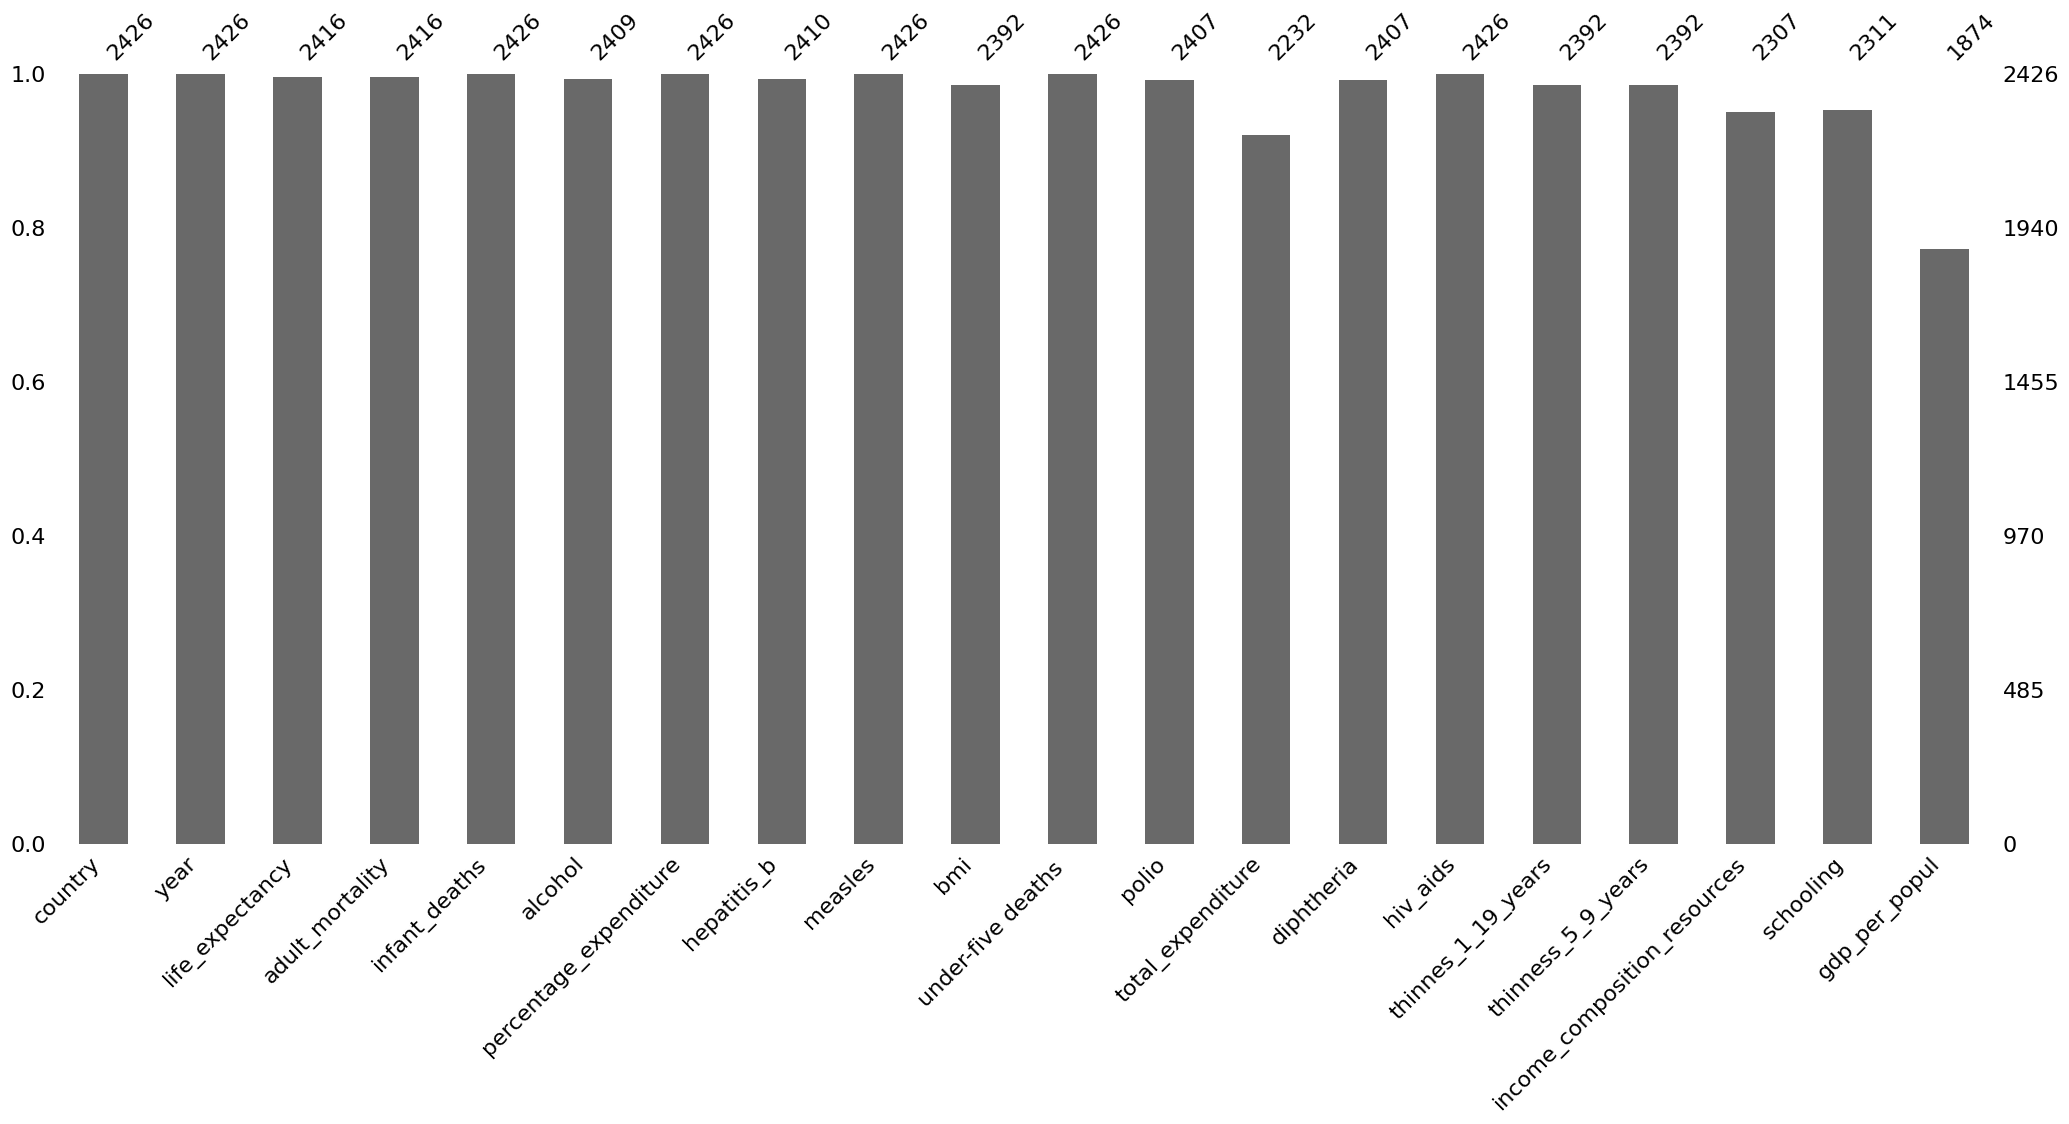

In [ ]:
msno.bar(df_developing)

<Axes: >

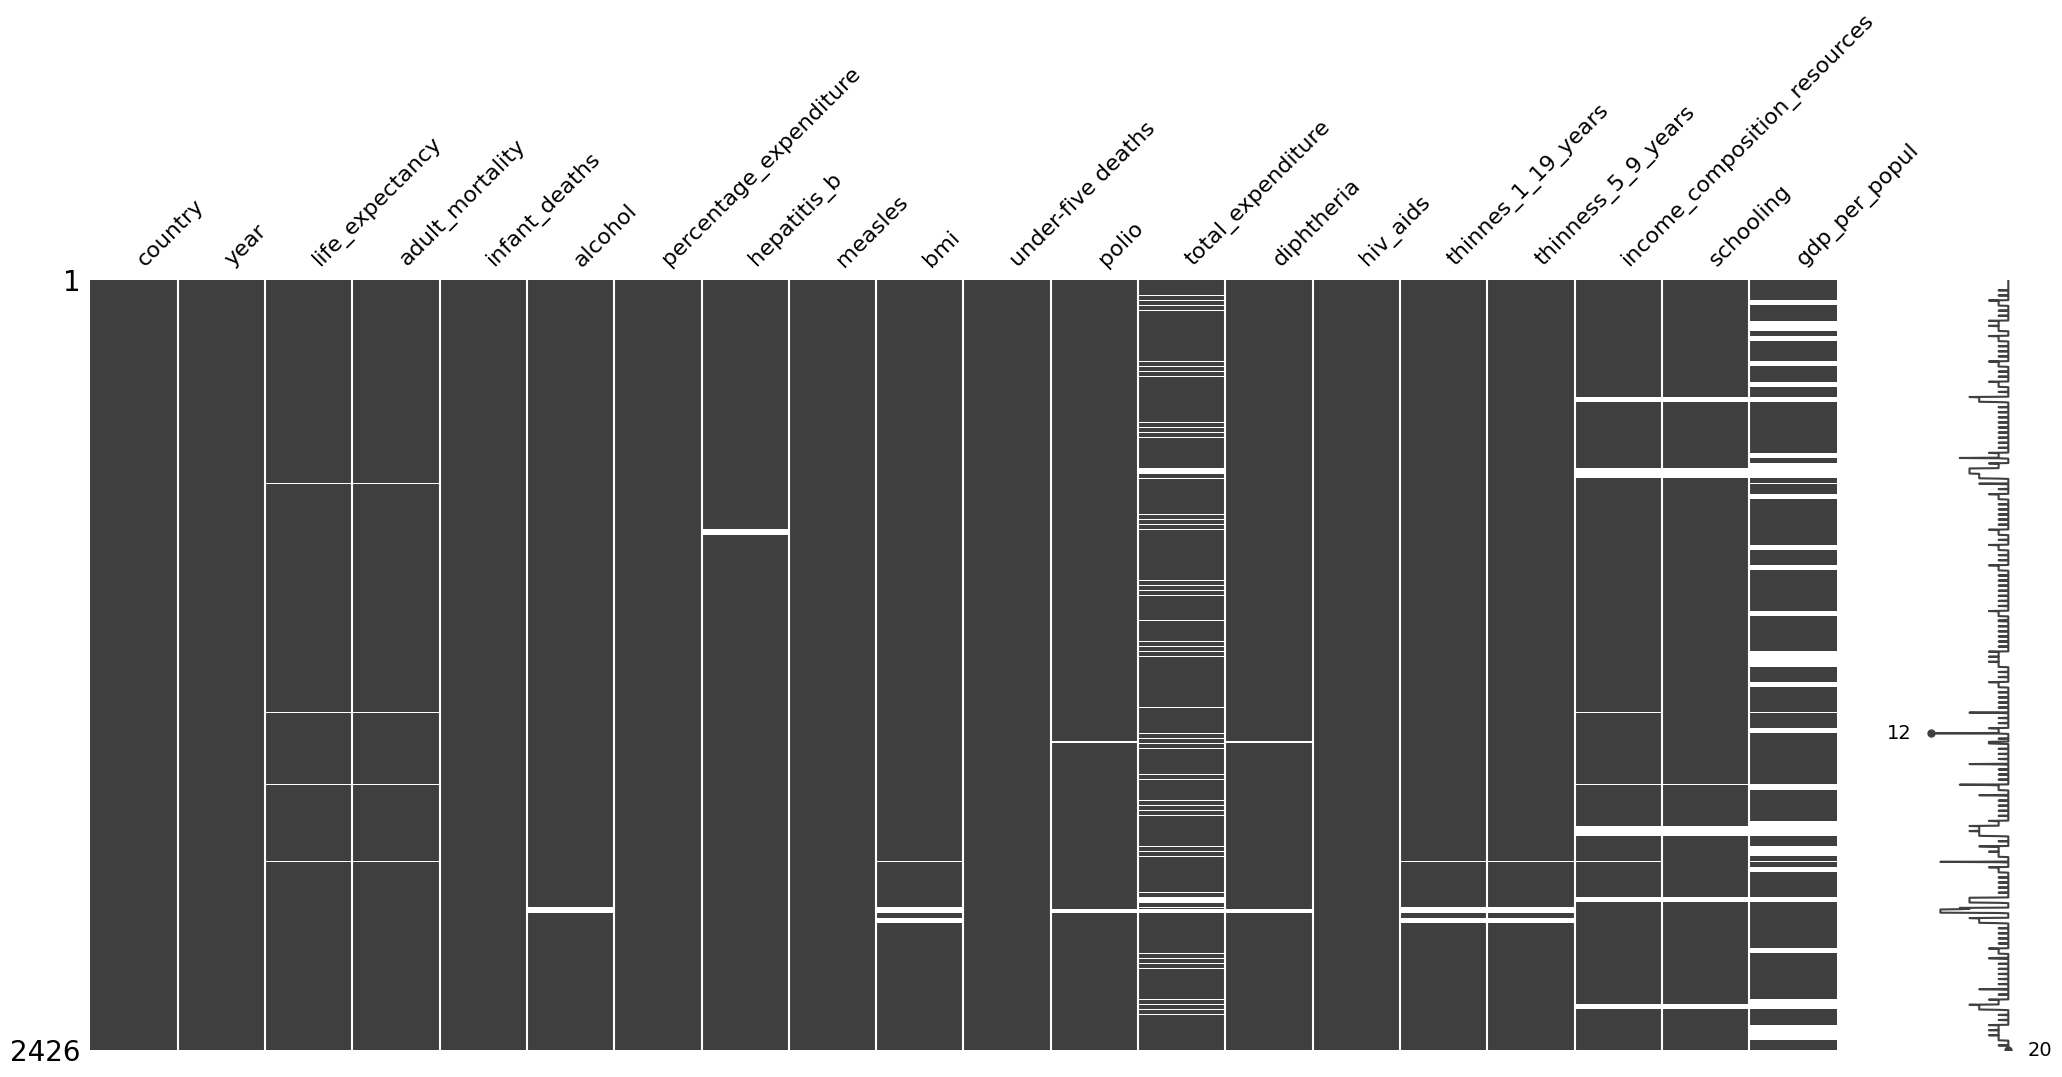

In [ ]:
msno.matrix(df_developing)

### Let us now create visualizations to get insights from data

- Firstly, starting by getting numeric and categorical columns.

In [ ]:
# getting numeric and categorical columns
cols_numeric = list(df_developing.select_dtypes(include=['number']).columns)
cols_categorical = df_developing.select_dtypes(include=["object"]).columns

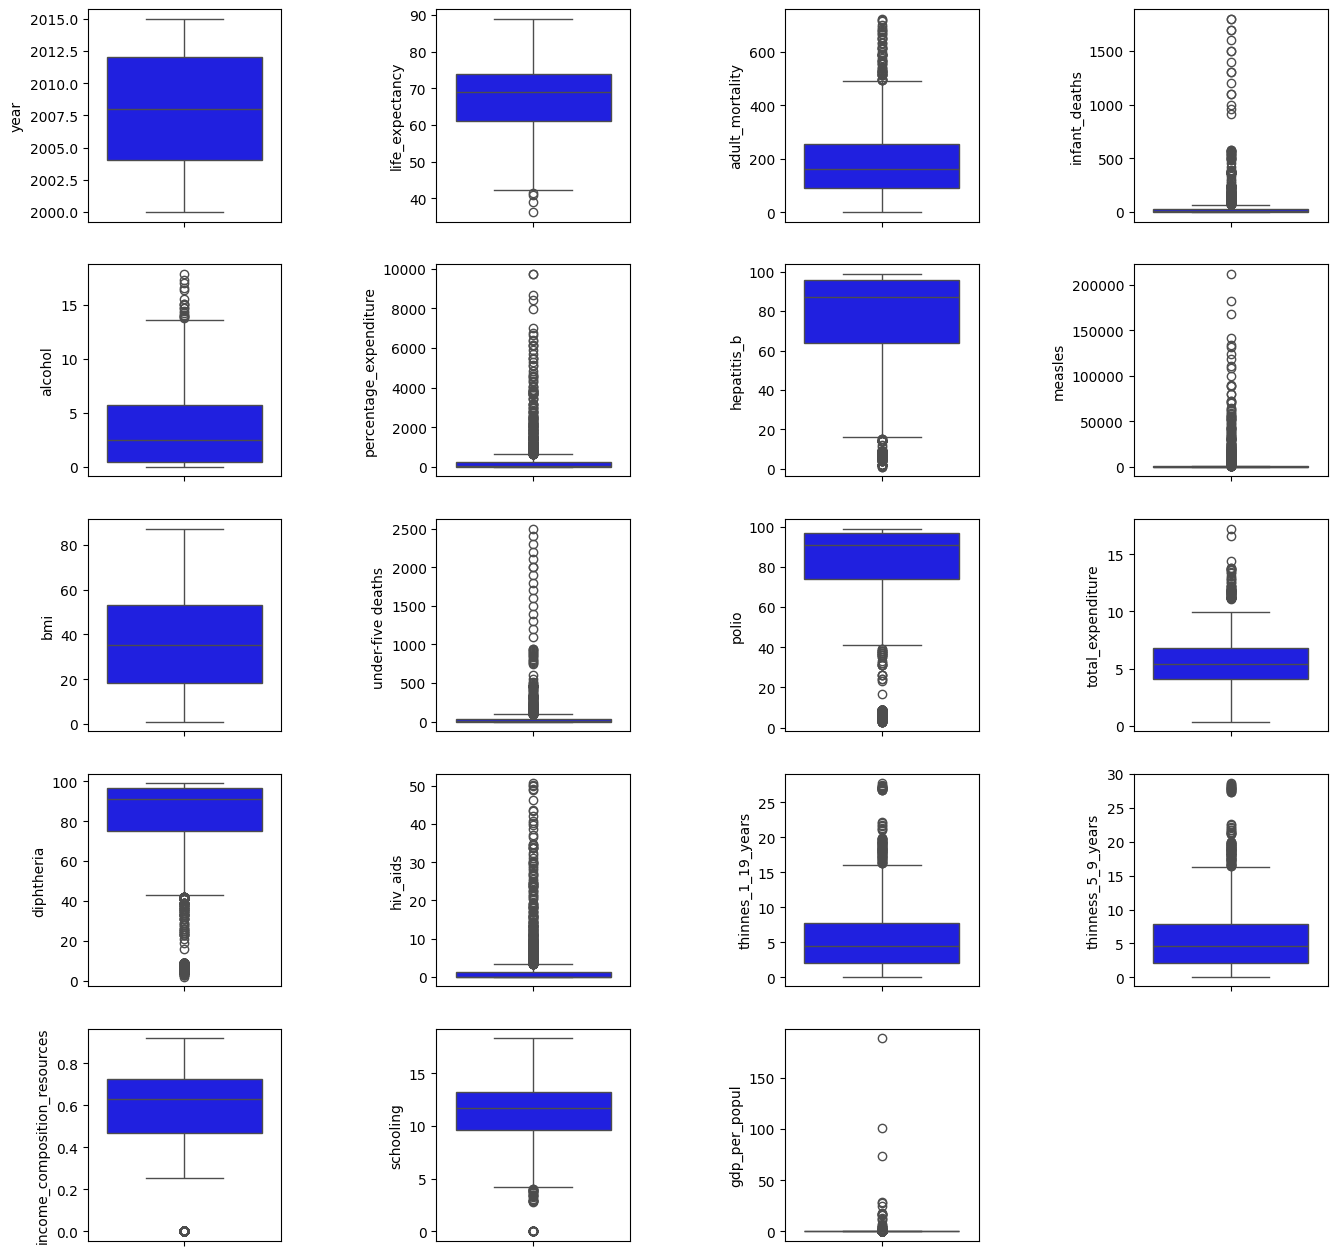

In [ ]:
# It creates a grid with n_rows and n_columns

nrows = 5 # number of rows
ncols = 4 # number of columns

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# It itereates over the grid ploting the figures
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.boxplot(y=df_developing[cols_numeric[idx]], data=df_developing, ax=ax,color='blue')
      idx += 1
    except:
      ax.set_visible(False)
plt.show()


- The box plots above point out that the data contain a great number of outliers, therefore, the median value of a given feature for a given country will be used to replace null values.

In [ ]:
# filling numeric columns with the median
df_developing[cols_numeric] = df_developing.groupby(['country'],as_index=False)[cols_numeric].transform(lambda x: x.fillna(x.median()))
# filling categorical columns with the mode
df_developing[cols_categorical] = df_developing.groupby(['country'],as_index=False)[cols_categorical].transform(lambda x: x.fillna(x.mode()))

- Visualizing again the null percentage in this dataset.

In [ ]:
df_developing.isnull().sum()/len(df)*100

country                          0.000000
year                             0.000000
life_expectancy                  0.340368
adult_mortality                  0.340368
infant_deaths                    0.000000
alcohol                          0.578625
percentage_expenditure           0.000000
hepatitis_b                      0.544588
measles                          0.000000
bmi                              1.157250
under-five deaths                0.000000
polio                            0.000000
total_expenditure                1.089176
diphtheria                       0.000000
hiv_aids                         0.000000
thinnes_1_19_years               1.157250
thinness_5_9_years               1.157250
income_composition_resources     4.050374
schooling                        3.914227
gdp_per_popul                   18.788291
dtype: float64

- Now, it is going to be dropped the remaining null values.

In [ ]:
df_developing = df_developing.dropna()

In [ ]:
# verifying the amount of null values
df_developing.isnull().sum()/len(df)*100

country                         0.0
year                            0.0
life_expectancy                 0.0
adult_mortality                 0.0
infant_deaths                   0.0
alcohol                         0.0
percentage_expenditure          0.0
hepatitis_b                     0.0
measles                         0.0
bmi                             0.0
under-five deaths               0.0
polio                           0.0
total_expenditure               0.0
diphtheria                      0.0
hiv_aids                        0.0
thinnes_1_19_years              0.0
thinness_5_9_years              0.0
income_composition_resources    0.0
schooling                       0.0
gdp_per_popul                   0.0
dtype: float64

- Now, null values are not present anymore, in spite of information loss by dropping some rows.

### Visualizations, again with better data.

- Violin plots are going to be plotted again to visualize the features's distribution after inputing and dropping null values.

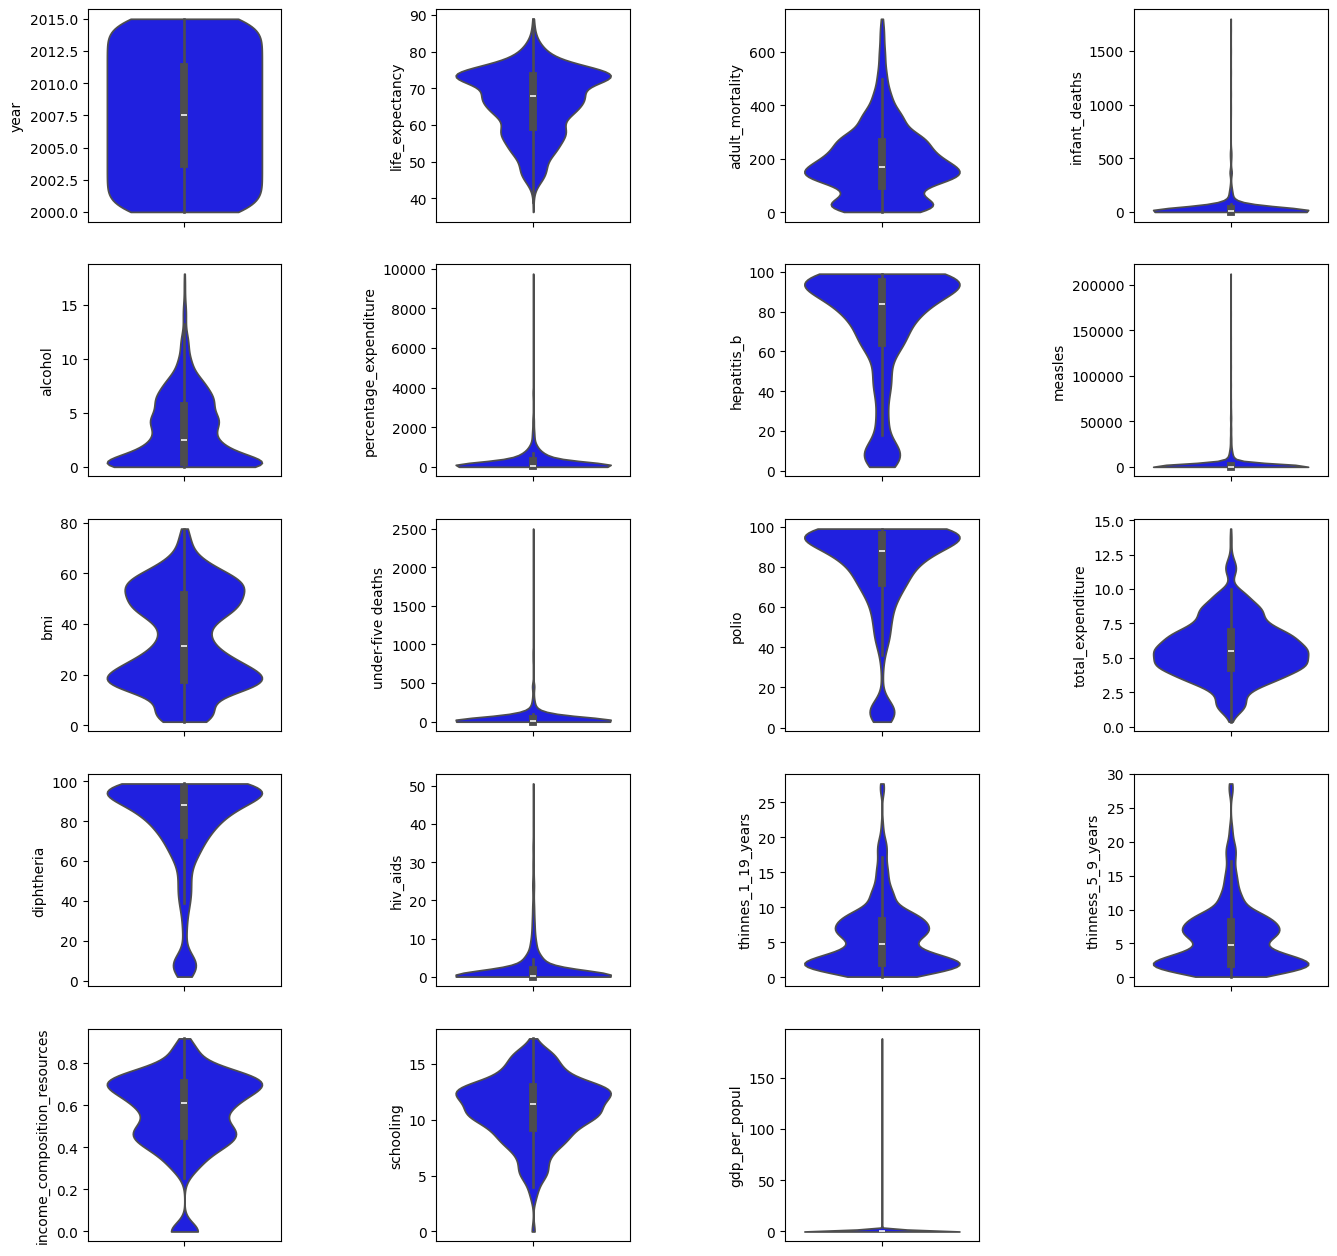

In [ ]:
# Creating a grid with n_rows and n_cols

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# Iterating over the grid and making plots
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.violinplot(y=df_developing[cols_numeric[idx]], data=df_developing,
                   ax=ax,color='blue',cut=0)

      idx += 1
    except:
      ax.set_visible(False)

plt.show()

- Now, visualizing data with box plots.

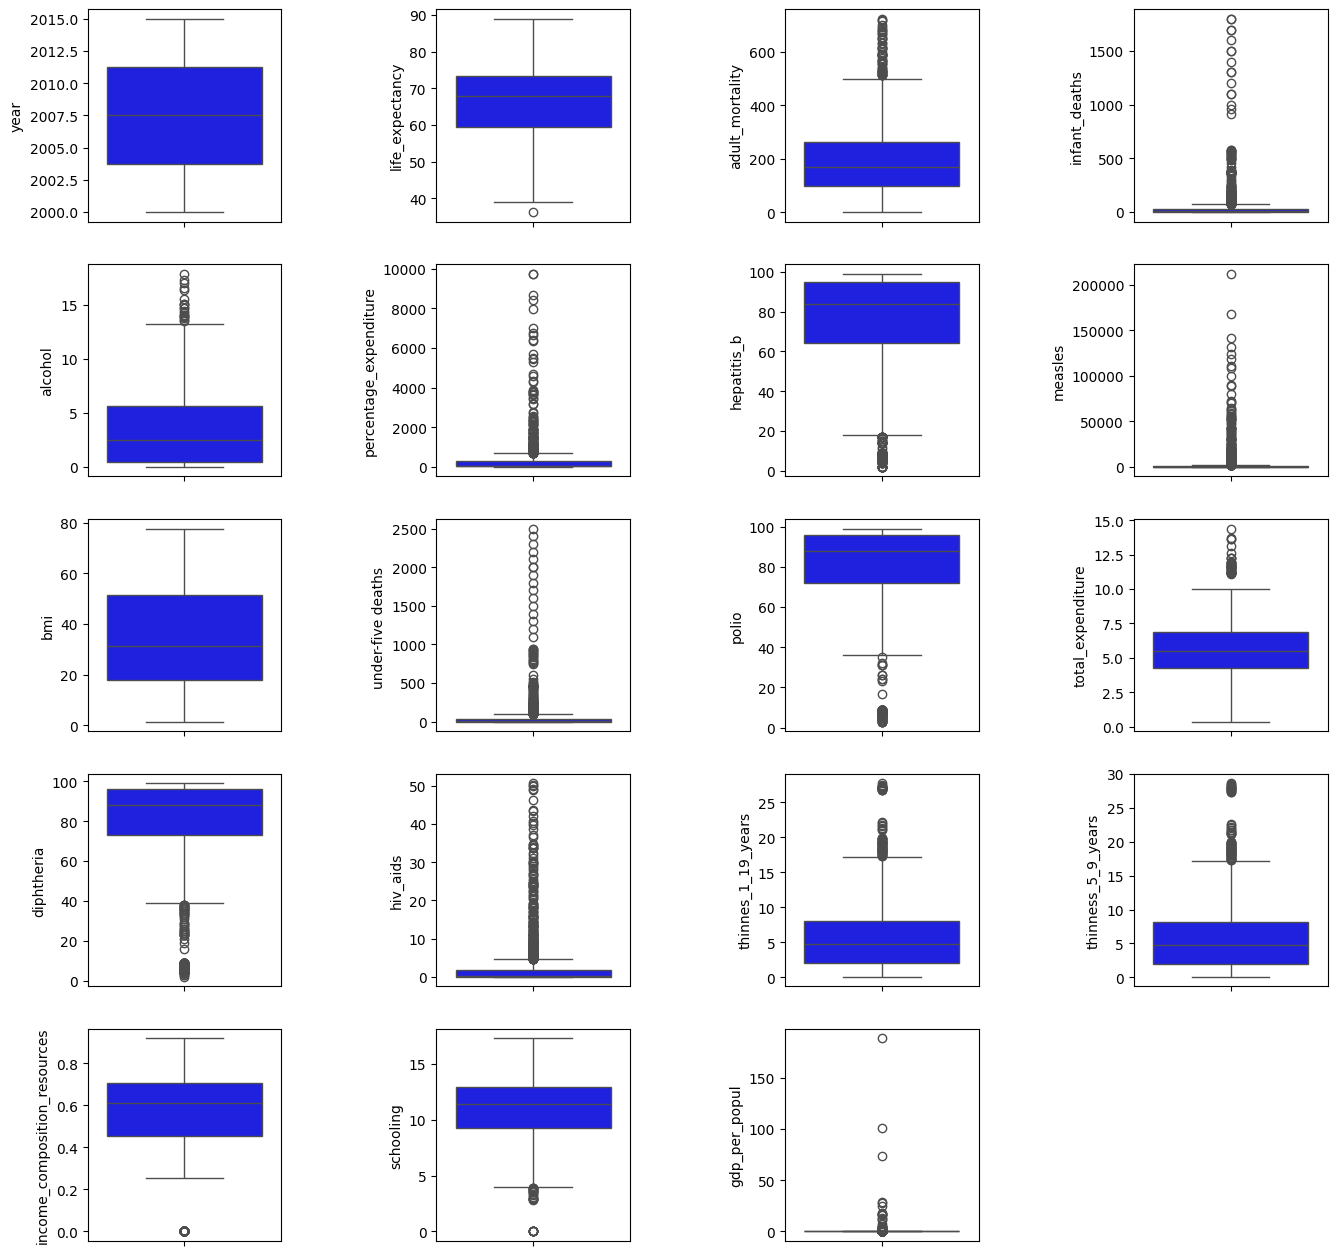

In [ ]:
# Creating a grid with n_rows and n_cols

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# Iterating over the grid and making plots
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.boxplot(y=df_developing[cols_numeric[idx]], data=df_developing,
                   ax=ax,color='blue')

      idx += 1
    except:
      ax.set_visible(False)

plt.show()


### Excluding Outliers

- Let us exclude countries with: 'income_composition_resources' less than 0.1, 'schooling' less than 1.5 and 'gdp_per_popul' greater than 15 (this value is too high for developing countries).

In [ ]:
# getting countries with income outliers
set_income = set(df_developing[df_developing['income_composition_resources']<0.1]['country'].unique())

In [ ]:
# getting countries with schooling outliers
set_schooling = set(df_developing[df_developing['schooling']<1.5]['country'].unique())

In [ ]:
# getting countries GDP per capita outliers
set_gdp_popul = set(df_developing[df_developing['gdp_per_popul']>15]['country'].unique())

In [ ]:
# dropping the aforementioned countries
countries_drop = list(set_income.union(set_schooling).union(set_gdp_popul))
df_developing = df_developing[~df_developing['country'].isin(countries_drop)]

- Inspecting the DataFrame.

In [ ]:
df_developing

country  year  life_expectancy  adult_mortality  infant_deaths  \
0     Afghanistan  2015             65.0            263.0             62   
1     Afghanistan  2014             59.9            271.0             64   
2     Afghanistan  2013             59.9            268.0             66   
3     Afghanistan  2012             59.5            272.0             69   
4     Afghanistan  2011             59.2            275.0             71   
...           ...   ...              ...              ...            ...   
2933     Zimbabwe  2004             44.3            723.0             27   
2934     Zimbabwe  2003             44.5            715.0             26   
2935     Zimbabwe  2002             44.8             73.0             25   
2936     Zimbabwe  2001             45.3            686.0             25   
2937     Zimbabwe  2000             46.0            665.0             24   

      alcohol  percentage_expenditure  hepatitis_b  measles   bmi  \
0        0.01               71.279624         65.0     1154  19.1   
1        0.01               73.523582         62.0      492  18.6   
2        0.01               73.219243         64.0      430  18.1   
3        0.01               78.184215         67.0     2787  17.6   
4        0.01                7.097109         68.0     3013  17.2   
...       ...                     ...          ...      ...   ...   
2933     4.36                0.000000         68.0       31  27.1   
2934     4.06                0.000000          7.0      998  26.7   
2935     4.43                0.000000         73.0      304  26.3   
2936     1.72                0.000000         76.0      529  25.9   
2937     1.68                0.000000         79.0     1483  25.5   

      under-five deaths   polio  total_expenditure  diphtheria  hiv_aids  \
0                     83    6.0               8.16        65.0       0.1   
1                     86   58.0               8.18        62.0       0.1   
2                     89   62.0               8.13        64.0       0.1   
3                     93   67.0               8.52        67.0       0.1   
4                     97   68.0               7.87        68.0       0.1   
...                  ...    ...                ...         ...       ...   
2933                  42   67.0               7.13        65.0      33.6   
2934                  41    7.0               6.52        68.0      36.7   
2935                  40   73.0               6.53        71.0      39.8   
2936                  39   76.0               6.16        75.0      42.1   
2937                  39   78.0               7.10        78.0      43.5   

      thinnes_1_19_years  thinness_5_9_years  income_composition_resources  \
0                   17.2                17.3                         0.479   
1                   17.5                17.5                         0.476   
2                   17.7                17.7                         0.470   
3                   17.9                18.0                         0.463   
4                   18.2                18.2                         0.454   
...                  ...                 ...                           ...   
2933                 9.4                 9.4                         0.407   
2934                 9.8                 9.9                         0.418   
2935                 1.2                 1.3                         0.427   
2936                 1.6                 1.7                         0.427   
2937                11.0                11.2                         0.434   

      schooling  gdp_per_popul  
0          10.1       0.000017  
1          10.0       0.001870  
2           9.9       0.000020  
3           9.8       0.000181  
4           9.5       0.000021  
...         ...            ...  
2933        9.2       0.000036  
2934        9.5       0.000036  
2935       10.0       0.000457  
2936        9.8       0.000044  
2937        9.8       0.000045  

[1424 rows x 20 colum

- Now, the dataframe has 1424 rows and 20 columns. The data has diminished in the data cleansing process, however, the data is much more reliable.

- Let us visualize, again, the data distribution in terms of box plots.

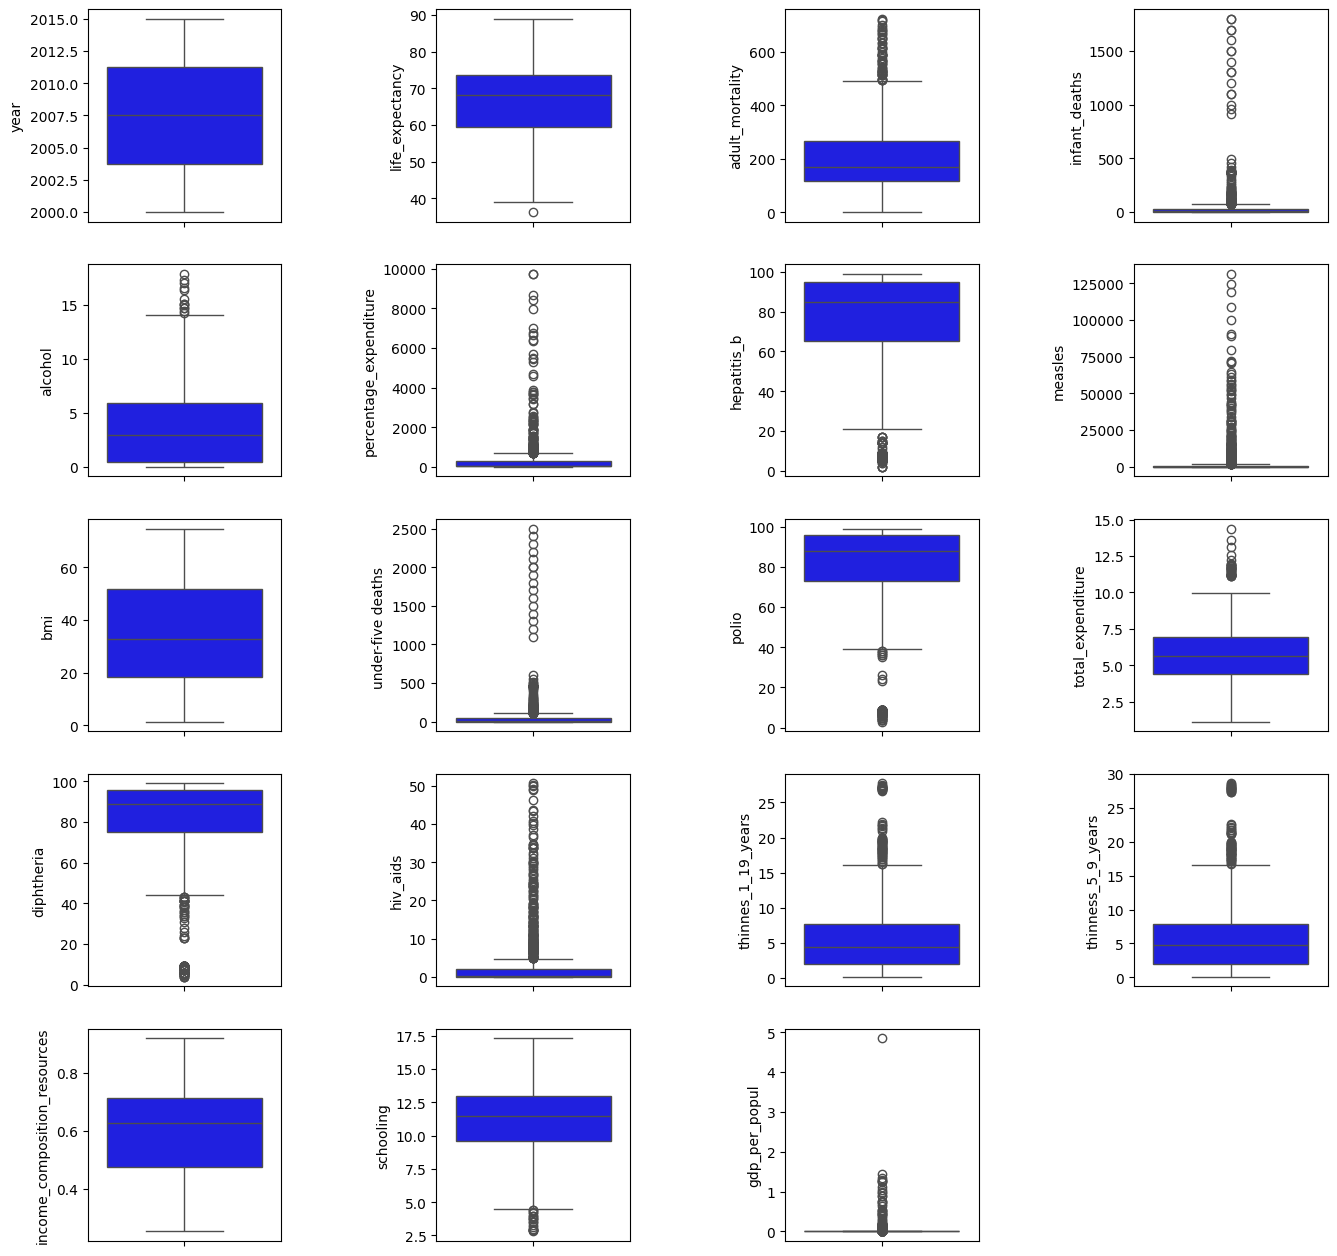

In [ ]:
# It creates a grid with n_rows and n_columns

nrows = 5 # number of rows
ncols = 4 # number of columns

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# It iterates over the grid, plotting the figures
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.boxplot(y=df_developing[cols_numeric[idx]], data=df_developing,
                   ax=ax,color='blue')

      idx += 1
    except:
      ax.set_visible(False)

plt.show()

- Let us visualize, again, the data distribution in terms of histogram plots. By this visualization, we can infer whether a given column is left- or right-skewed and decide to use whether logarithm of root square feature transformation.

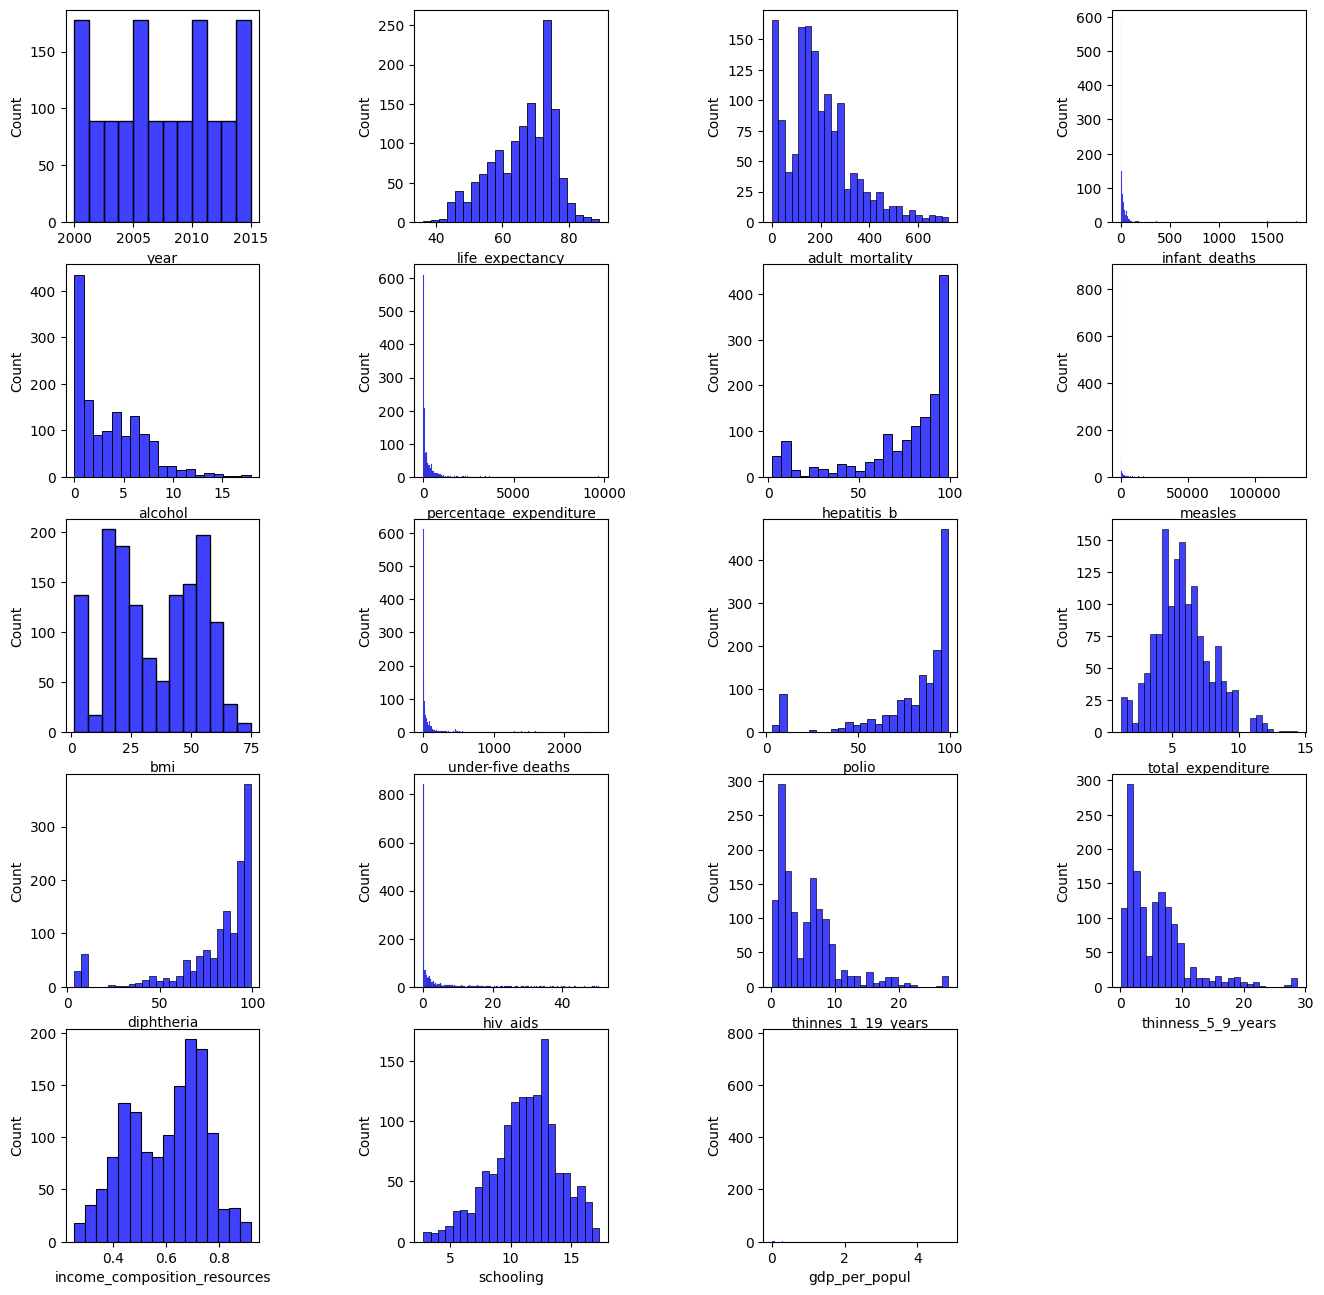

In [ ]:
# It creates a grid with n_rows and n_cols

nrows = 5 # number of rows
ncols = 4 # number of columns

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# It iterates over the grid plotting the figures
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.histplot(x=df_developing[cols_numeric[idx]], data=df_developing,
                   ax=ax,color='blue')

      idx += 1
    except:
      ax.set_visible(False)

plt.show()


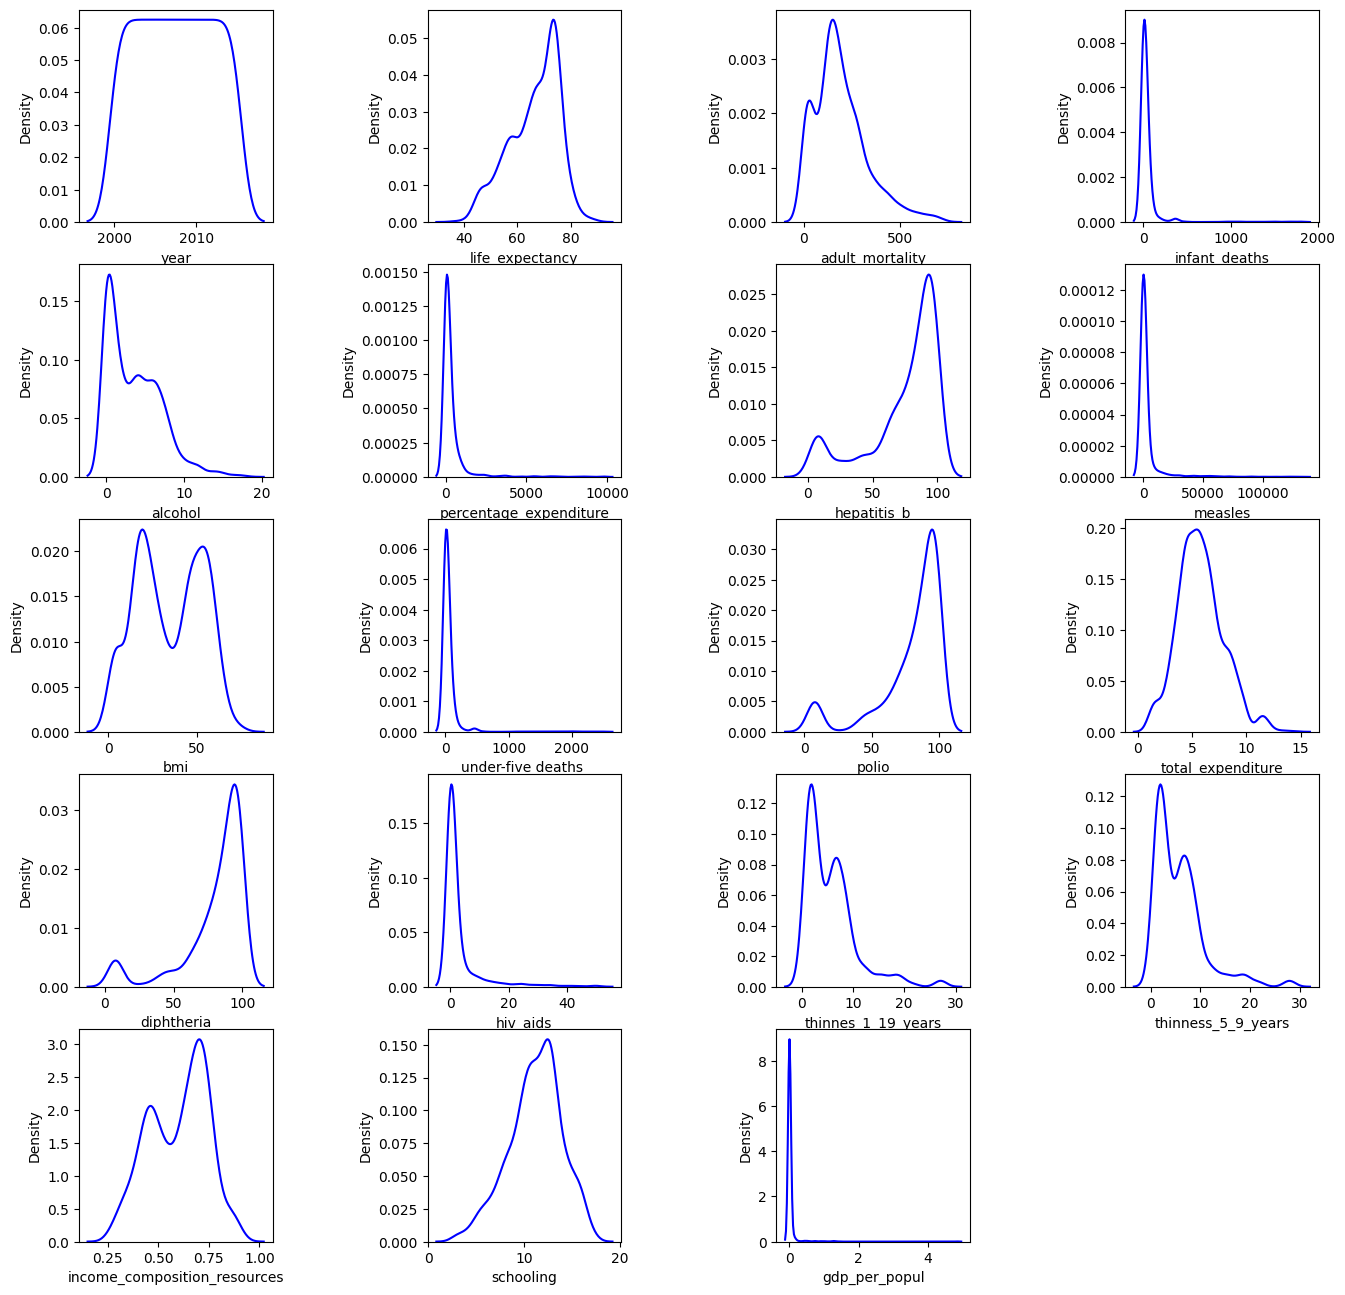

In [ ]:
# It creates a grid with n_rows and n_cols

nrows = 5 # number of rows
ncols = 4 # number of columns

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# It iterates over the grid plotting the figures
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.kdeplot(x=df_developing[cols_numeric[idx]], data=df_developing,
                   ax=ax,color='blue')

      idx += 1
    except:
      ax.set_visible(False)

plt.show()


### Feature Engineering: Making Features "Gaussian-like"

- Now logarithm or square root transformations of the columns will take place. When the attribute is right-skewed, logarithmic transformation will be applied, otherwise the square-root transformation takes place. Here, the transformations' choice will be performed by visual inspection, but it could have been done programatically.


In [ ]:
df_developing['life_expectancy'] = np.sqrt(df_developing['life_expectancy'])
df_developing['adult_mortality'] = np.log1p(df_developing['adult_mortality'])
df_developing['infant_deaths'] = np.log1p(df_developing['infant_deaths'])
df_developing['alcohol'] = np.log1p(df_developing['alcohol'])

df_developing['percentage_expenditure'] = np.log1p(df_developing[ 'percentage_expenditure'])
df_developing['hepatitis_b'] = np.sqrt(df_developing['hepatitis_b'])
df_developing['measles'] = np.log1p(df_developing['measles'])
df_developing['bmi'] = np.sqrt(df_developing['bmi'])

df_developing['under-five deaths '] = np.log1p(df_developing['under-five deaths '])
df_developing['polio'] = np.sqrt(df_developing['polio'])
df_developing['total_expenditure'] = np.log1p(df_developing['total_expenditure'])
df_developing['diphtheria'] = np.sqrt(df_developing['diphtheria'])

df_developing['hiv_aids'] = np.log1p(df_developing['hiv_aids'])
df_developing['thinnes_1_19_years'] = np.log1p(df_developing['thinnes_1_19_years'])
df_developing['thinness_5_9_years'] = np.log1p(df_developing['thinness_5_9_years'])
df_developing['income_composition_resources'] = np.sqrt(df_developing['income_composition_resources'])

df_developing['schooling'] = np.sqrt(df_developing['schooling'])
df_developing['gdp_per_popul'] = np.sqrt(df_developing['gdp_per_popul'])


- Visualizing again the data distribution.

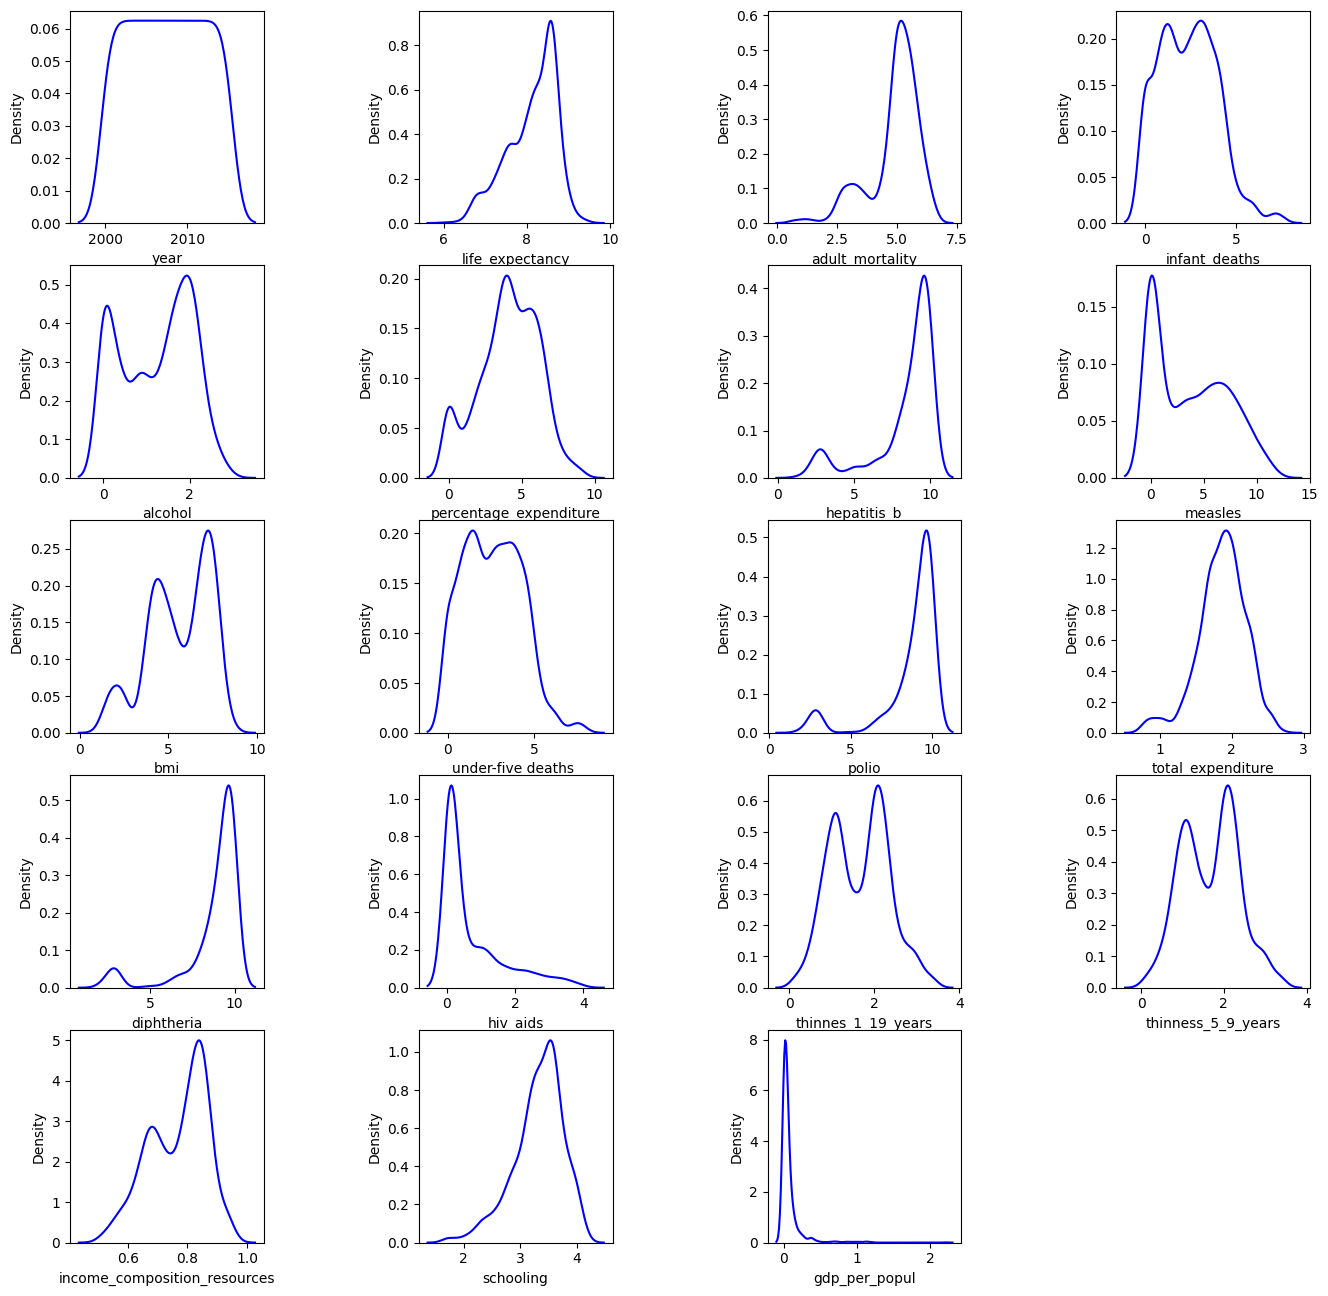

In [ ]:
# It creates a grid with n_rows and n_cols

nrows = 5 # number of rows
ncols = 4 # number of columns

fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
plt.subplots_adjust(wspace=0.8)

# It iterates over the grid plotting the figures
idx = 0
for row in range(nrows):
  for col in range(ncols):
    try:
      ax = axes[row, col]
      sns.kdeplot(x=df_developing[cols_numeric[idx]], data=df_developing,
                   ax=ax,color='blue')

      idx += 1
    except:
      ax.set_visible(False)

plt.show()


### Interactive Visualizations with **PlotLy**

- Let us see an animation of the Life Expectancy versus year for all the investigated countries.

In [ ]:
fig=px.line(df_developing.sort_values(by='year'),x='year',y='life_expectancy',animation_frame='country',
            animation_group='year',color='country',markers=True,template='plotly_dark',title='<b> Country-wise Life Expectancy over Years')
fig.show()


- Let us see a scatter plot of the Adult Mortality versus Life Expectancy for all the investigated countries. There seems to be a negative correlation between Adult Mortality and Life Expectancy.

In [ ]:
px.scatter(df_developing,y='adult_mortality',x='life_expectancy',color='country',size='life_expectancy',
           template='plotly_dark',opacity=0.6,title='<b> Life Expectancy Versus Adult Mortality')

- Let us see a scatter plot of the Infant Deaths versus Life Expectancy for all the investigated countries. There seems to be a negative correlation between Infant Deaths and Life Expectancy.

In [ ]:
px.scatter(df_developing,y='infant_deaths',x='life_expectancy',color='country',size='life_expectancy',
           template='plotly_dark',opacity=0.6,title='<b> Life Expectancy Versus Infant Deaths')

### Now, making a plot to get insights between Life expectancy and others attributes.

In [ ]:
# Function to plot the target variable against some features
def get_pairs(data, alvo, atributos, n):

    # Line groups with n plots by line
    row_groups = [atributos[i:i+n] for i in range(0, len(atributos), n)]

    # Loop over the line groups in order to create a plot
    for ind in row_groups:
        plot = sns.pairplot(x_vars = ind, y_vars = alvo, data = data, kind = "reg", height = 3)

    return

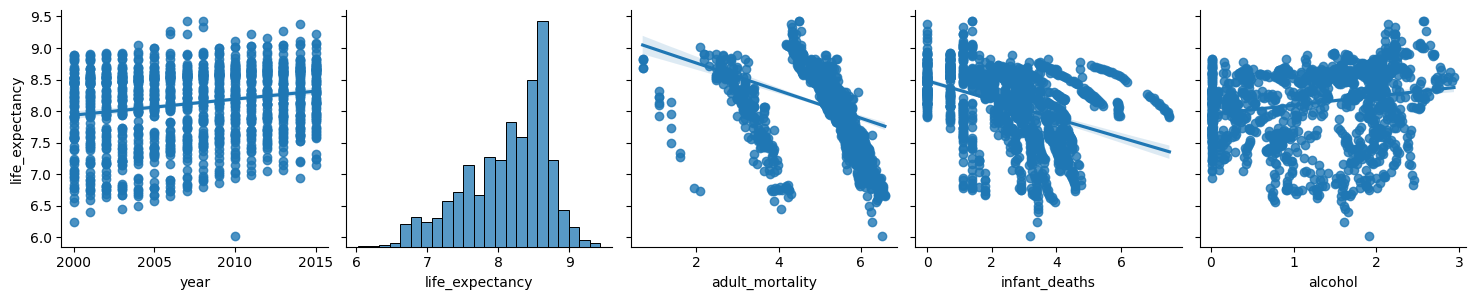

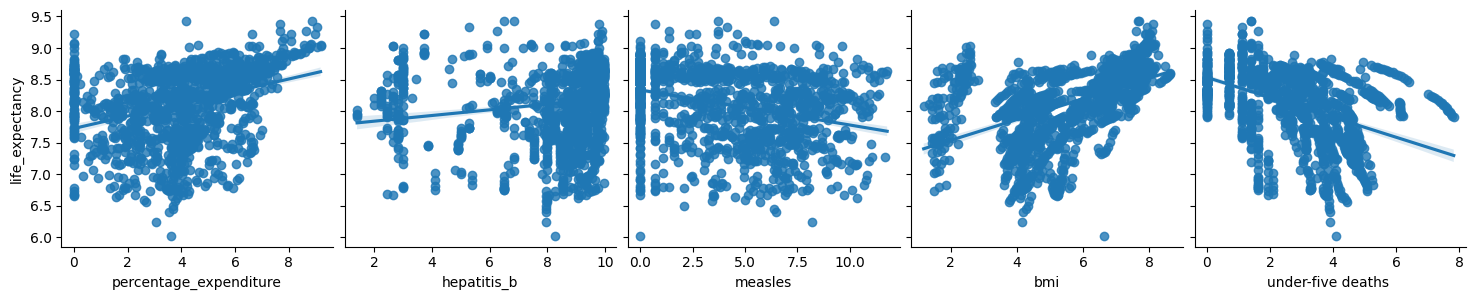

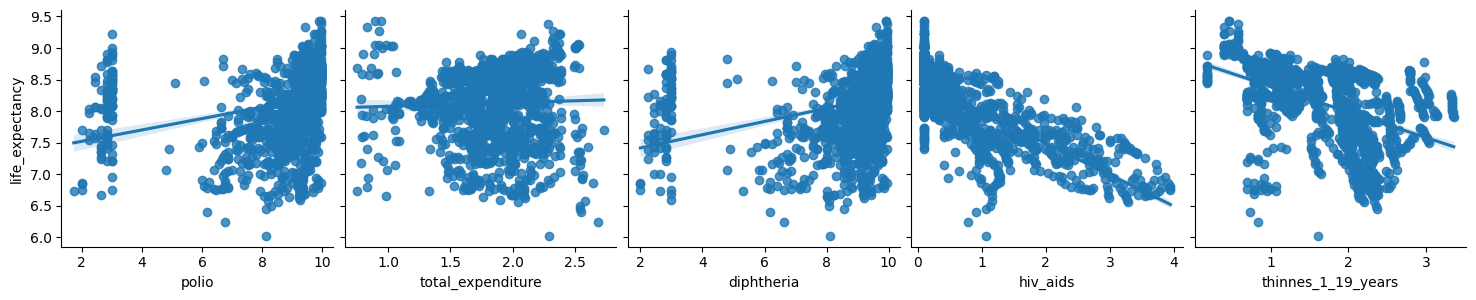

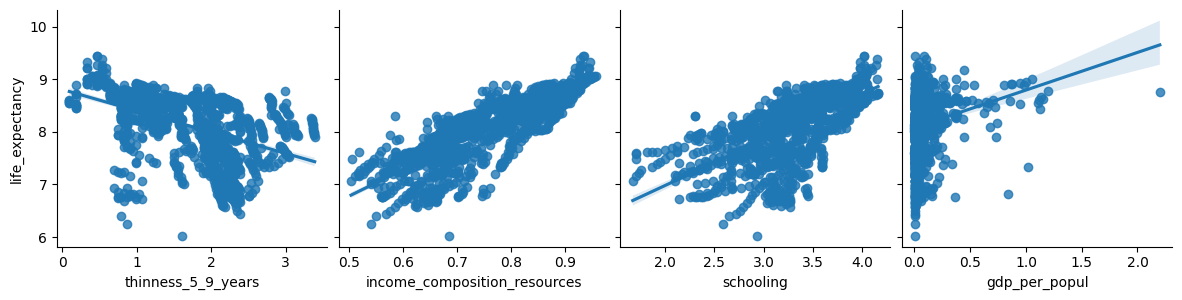

In [ ]:
target = ['life_expectancy']
get_pairs(df_developing, target, cols_numeric, 5)

### Correlation's Analysis

- Let us start by sorting the most correlated features correlated with 'life_expectancy', from the most positive correlation up to the most negative one. It is going to be addressed the Spearman correlation method, because it is a non-parametric method (it does not make assumptions about data's distribution) and there is clearly no evidence that the current data follow a normal distribution.

<Axes: >

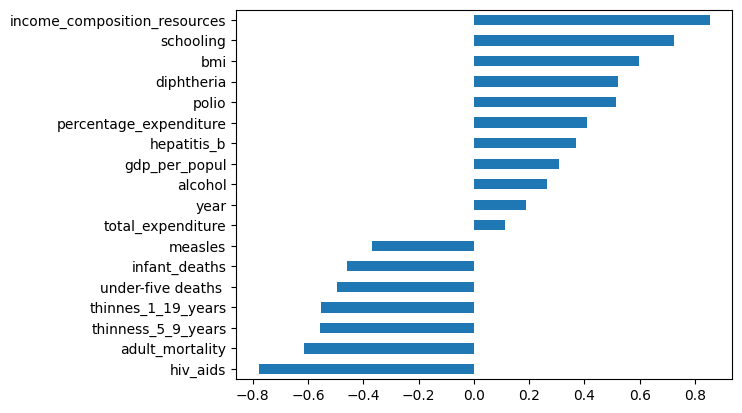

In [ ]:
# plotting the correlation of life expectancy with all other variables
pd.Series(df_developing.corr(method='spearman')['life_expectancy'].drop('life_expectancy')).sort_values().plot(kind='barh')

### Now, the correlations in absolute value.

<Axes: >

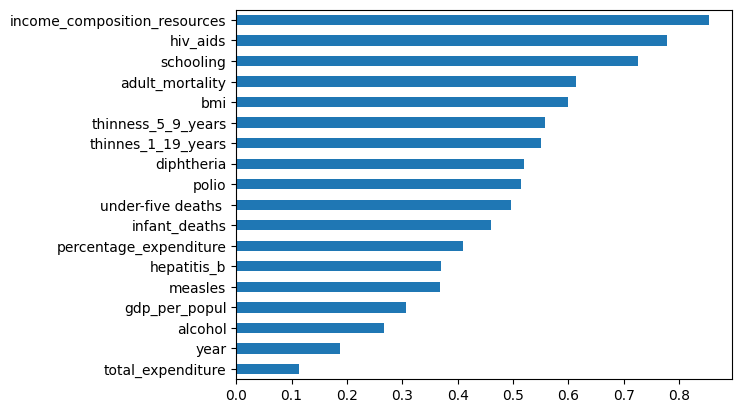

In [ ]:
# plotting the correlation of life expectancy with all other variables, but in absolute value
pd.Series(df_developing.corr(method='spearman').abs()['life_expectancy'].drop('life_expectancy')).sort_values().plot(kind='barh')

#### Heatmap of features's correlation

- Now it is going to be addressed the heatmap correlation plot. Afterwards, it is going to be performed a multicollinearity analysis between features (excluding the target, Life Expectancy).

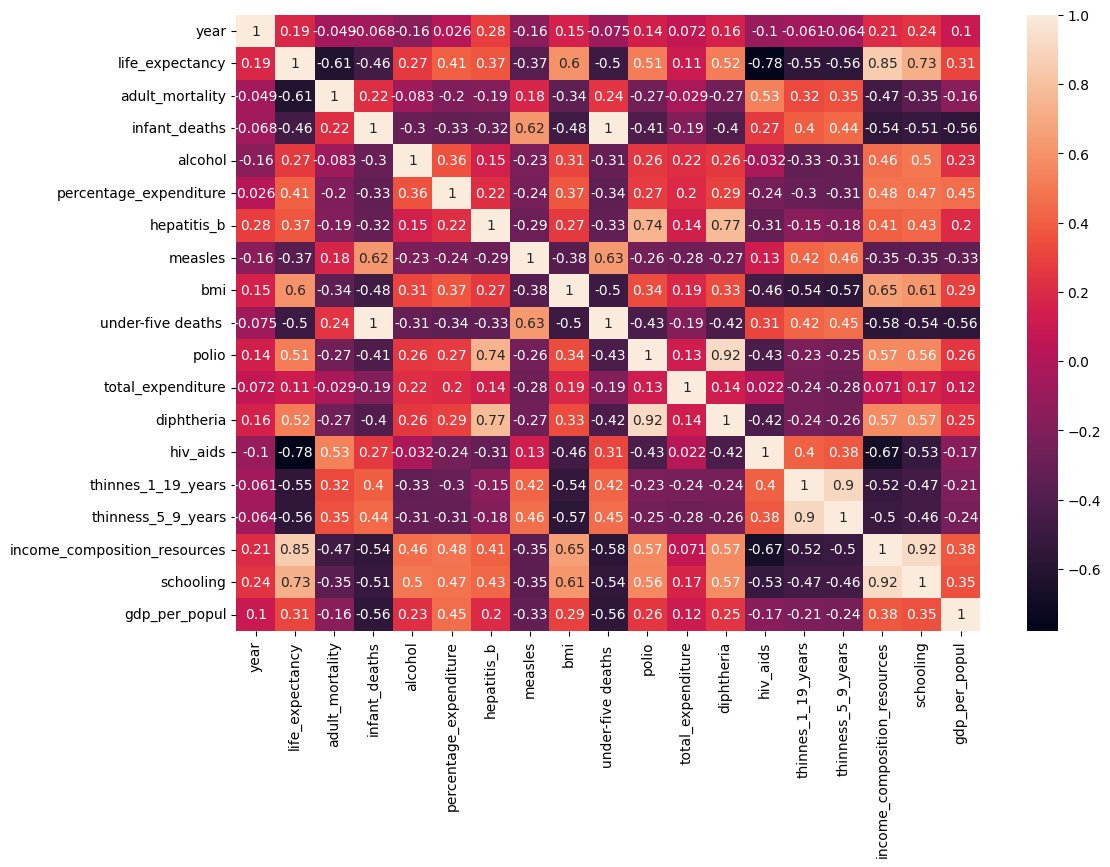

In [ ]:
plt.figure(figsize=[12,8])

sns.heatmap(df_developing.corr(method='spearman'),annot=True)

plt.show()

In [ ]:
# correltion matrix excluding the target
corr_matrix = df_developing.drop(columns=['life_expectancy']).corr(method='spearman')

# Set a correlation threshold (you can adjust this value)
correlation_threshold = 0.8

# Find highly correlated features
highly_correlated_features = set()

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

# Display the list of highly correlated features
print("Highly correlated features:", highly_correlated_features)

Highly correlated features: {'thinness_5_9_years', 'schooling', 'diphtheria', 'under-five deaths '}


- Dropping the highly correlated features.

In [ ]:
#cols_drop_corr = ['schooling','under-five deaths ','thinness_5_9_years','diphtheria']
cols_drop_corr = highly_correlated_features
df_developing = df_developing.drop(columns=cols_drop_corr)

- Plotting the features's correlation with the Target variable of the remaining columns.

<Axes: >

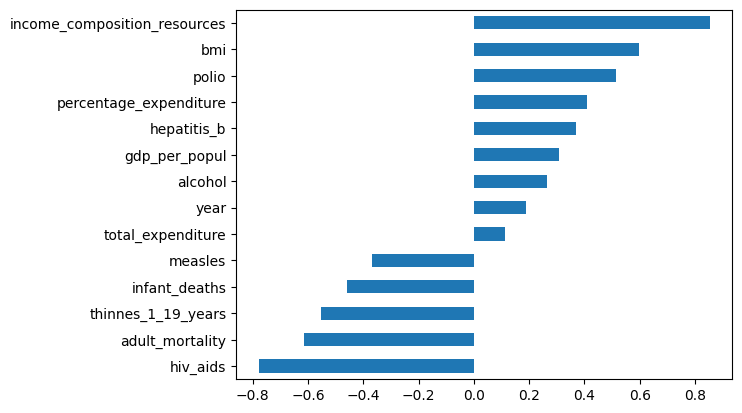

In [ ]:
pd.Series(df_developing.corr(method='spearman')['life_expectancy'].drop('life_expectancy')).sort_values().plot(kind='barh')

#### Dropping problematic Countries from the Analysis, because this countries show unrealistic values.

In [ ]:
list_africa_drop = ['Angola','Sierra Leone']

df_developing = df_developing[~df_developing['country'].isin(list_africa_drop)]

## Statistical and Machine Learning Analysis

In [ ]:
# getting the features
X_developing = df_developing.drop(columns=['life_expectancy'])
X_developing = X_developing.drop(columns=['country'])

# getting the target
y_developing = df_developing['life_expectancy']

In [ ]:
# Splitting data into training and testing sets and keeping the indices of the orignal DataFrame
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_developing, y_developing,X_developing.index,test_size=0.25)

#### Now, normalizing the data, because VIF and Regression Models work better in this way.

In [ ]:
scaler_developing = MinMaxScaler()
# fitting the training set
scaler_developing.fit(X_train)
# transforming training and testing sets
X_train = pd.DataFrame(scaler_developing.transform(X_train),columns=X_train.columns,index=indices_train)
X_test = pd.DataFrame(scaler_developing.transform(X_test),columns=X_test.columns,index=indices_test)

In [ ]:
X_train.head(5)

year  adult_mortality  infant_deaths   alcohol  \
875   0.400000         0.773135       0.000000  0.975813   
1131  0.400000         0.454530       0.385584  0.669946   
1876  0.000000         0.776694       0.214703  0.518604   
1631  0.133333         0.471262       0.548402  0.141862   
1363  0.933333         0.824709       0.539354  0.000000   

      percentage_expenditure  hepatitis_b   measles       bmi     polio  \
875                 0.599096     0.976208  0.282718  0.842938  0.974455   
1131                0.226335     0.800406  0.000000  0.680289  0.730861   
1876                0.303584     0.901655  0.000000  0.714545  0.908133   
1631                0.167942     0.875618  0.557975  0.373776  0.762560   
1363                0.560401     0.958034  0.498215  0.449781  0.961481   

      total_expenditure  hiv_aids  thinnes_1_19_years  \
875            0.533154  0.000000            0.298963   
1131           0.580482  0.354807            0.467900   
1876           0.556584  0.062764            0.308964   
1631           0.625129  0.285920            0.231202   
1363           0.581986  0.329396            0.627621   

      income_composition_resources  gdp_per_popul  
875                       0.885872       0.138846  
1131                      0.376483       0.003355  
1876                      0.541366       0.006633  
1631                      0.114092       0.002317  
1363                      0.517777       0.024303

### VIF (Variance Inflation Factor) Features's Analyses

- Now, let us address VIF analysis for the features in this dataset and drop columns accordingly in such a way that the features VIFs of all features be in a reasonable value.

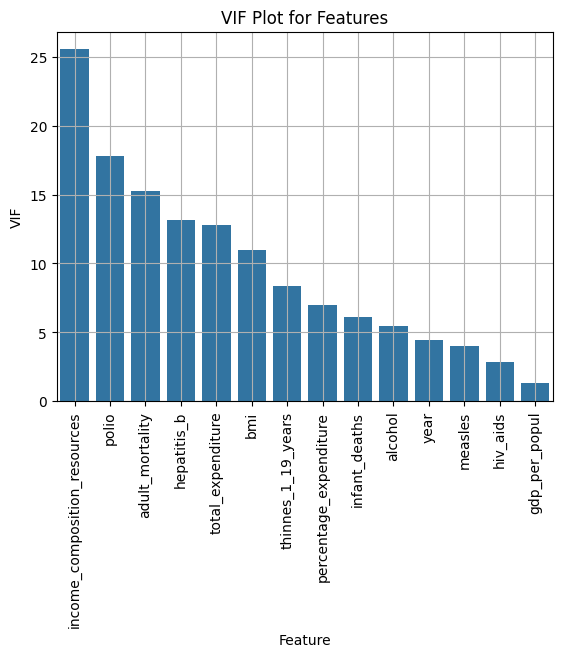

In [ ]:
# Calculate VIFs using statsmodels
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_train.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

- To reduce VIF, let us drop 'polio' and 'adult_mortality'. Note that the transformations performed in the training set should also be performed in the testing set.

In [ ]:
X_train = X_train.drop(columns=['polio','adult_mortality'])
X_test = X_test.drop(columns=['polio','adult_mortality'])

#### Calculating VIFs again

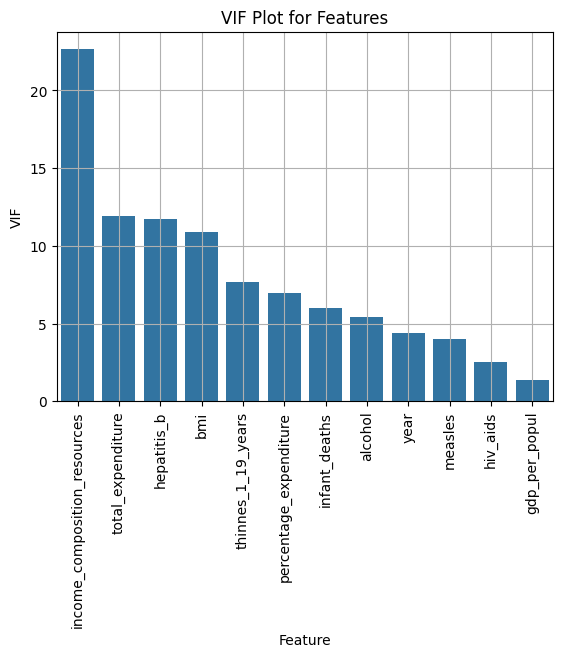

In [ ]:
# Calculate VIFs using statsmodels

vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_train.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

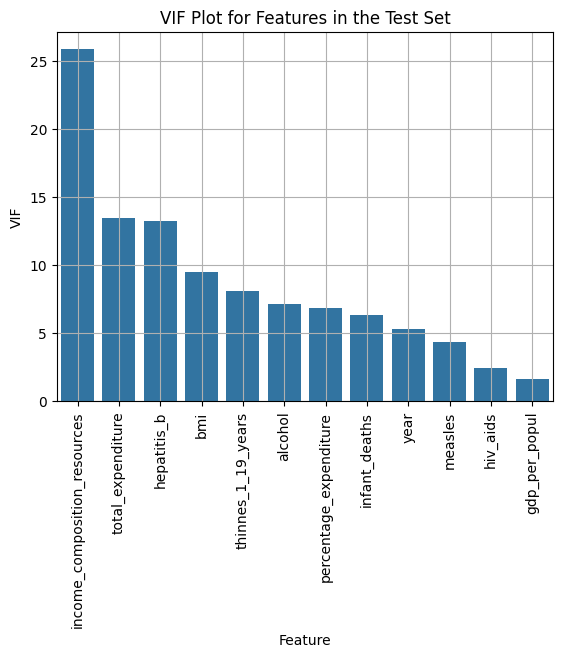

In [ ]:
# Calculate VIFs using statsmodels
vif = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_test.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features in the Test Set")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

- To reduce features's VIF, let us drop 'income_composition_resources'.

In [ ]:
X_train = X_train.drop(columns=['income_composition_resources'])
X_test = X_test.drop(columns=['income_composition_resources'])

#### Calculating VIFs again

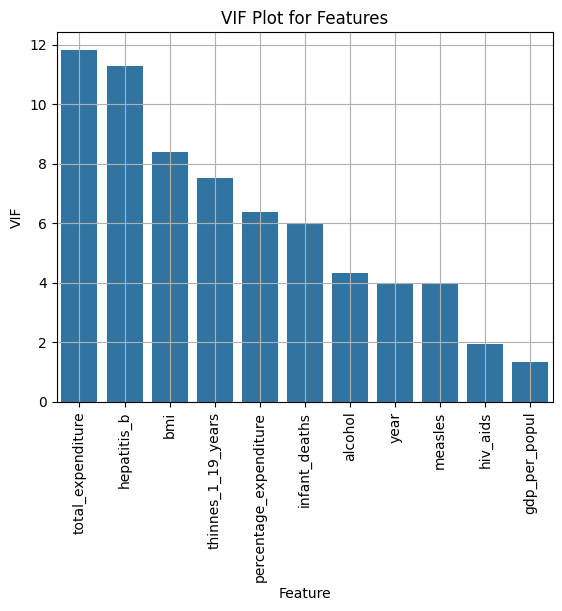

In [ ]:
# Calculate VIFs using statsmodels

vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_train.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

- To reduce features's VIF, let us drop 'total_expenditure'.

In [ ]:
X_train = X_train.drop(columns=['total_expenditure'])
X_test = X_test.drop(columns=['total_expenditure'])

#### Calculating VIFs again

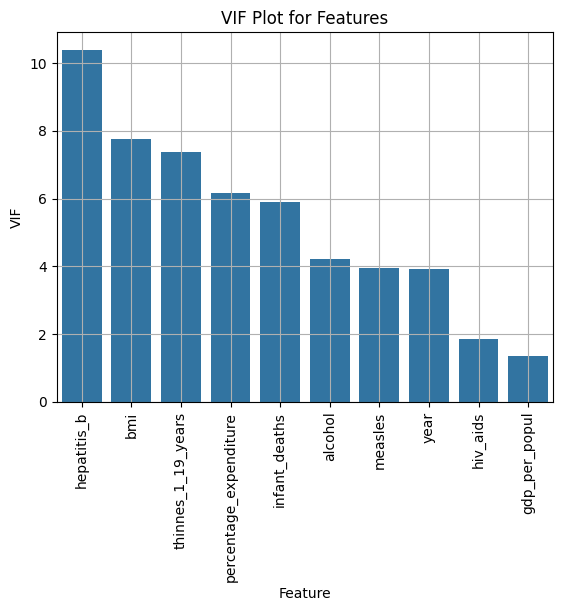

In [ ]:
# Calculate VIFs using statsmodels

vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_train.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

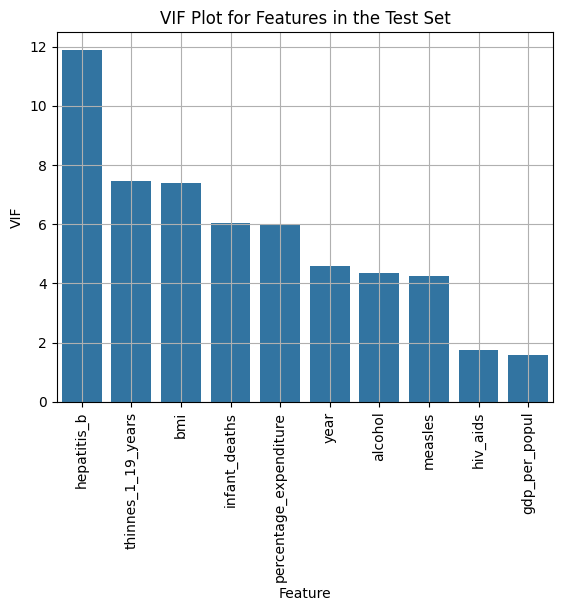

In [ ]:
# Calculate VIFs using statsmodels

vif = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_test.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features in the Test Set")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

- To reduce VIF, let us drop more columns.

In [ ]:
X_train = X_train.drop(columns=['measles','hepatitis_b','gdp_per_popul'])
X_test = X_test.drop(columns=['measles','hepatitis_b','gdp_per_popul'])

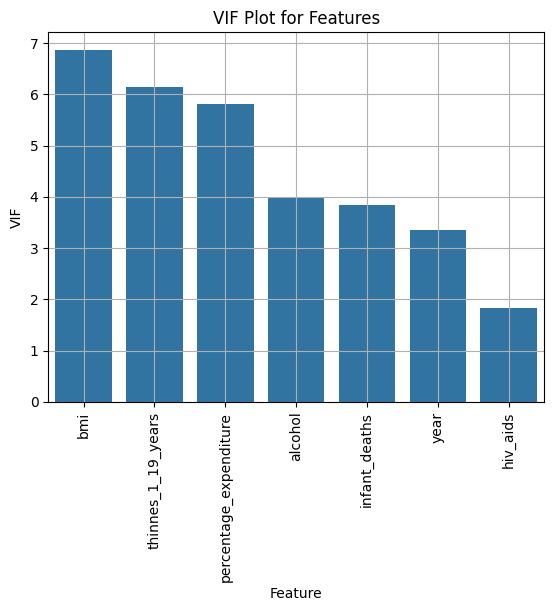

In [ ]:
# Calculate VIFs using statsmodels

vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_train.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

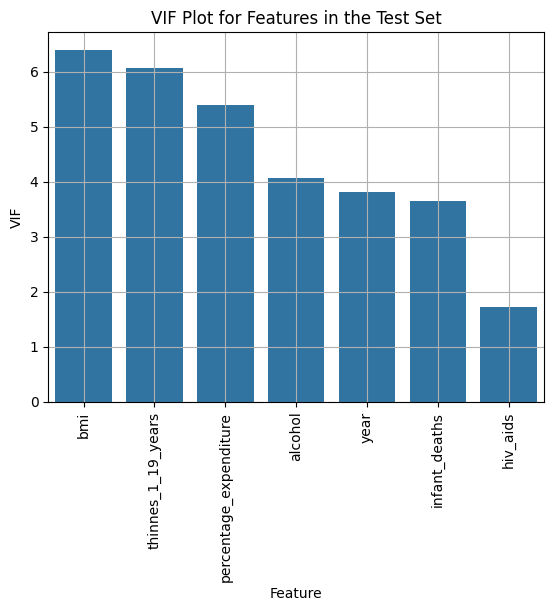

In [ ]:
# Calculate VIFs using statsmodels

vif = [variance_inflation_factor(X_test.values, i) for i in range(X_test.shape[1])]

# Create the VIF DataFrame
vif_df = pd.DataFrame({"feature": X_test.columns, "VIF": vif})

# Sort by VIF in descending order
vif_df = vif_df.sort_values(by=["VIF"], ascending=False)

# Create the VIF plot
sns.barplot(x="feature", y="VIF", data=vif_df)
plt.xlabel("Feature")
plt.ylabel("VIF")
plt.title("VIF Plot for Features in the Test Set")
plt.xticks(rotation=90)  # Rotate feature names for better readability
plt.grid(True)
plt.show()

## Statistical Modeling

- Let us use statsmodels to fit a linear regression in such a dataset.

In [ ]:
# target and features
y_train = y_train
X_fit = sm.add_constant(X_train)
# model
model_developing = OLS(y_train, X_fit)
results = model_developing.fit()
# summary of the modeling
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     680.0
Date:                Fri, 23 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:45:42   Log-Likelihood:                 25.083
No. Observations:                1044   AIC:                            -34.17
Df Residuals:                    1036   BIC:                             5.440
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      8.0824      0.044    182.764      0.000       7.996       8.169
year                       0.1834      0.024      7.527      0.000       0.136       0.231
infant_deaths             -0.2222      0.041     -5.390      0.000      -0.303      -0.141
alcohol                    0.3032      0.031      9.811      0.000       0.243       0.364
percentage_expenditure     0.2876      0.037      7.792      0.000       0.215       0.360
bmi                        0.2472      0.038      6.509      0.000       0.173       0.322
hiv_aids                  -1.6550      0.034    -49.208      0.000      -1.721      -1.589
thinnes_1_19_years        -0.1704      0.043     -3.925      0.000      -0.256      -0.085
==============================================================================
Omnibus:                        3.305   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.301
Skew:                          -0.111   Prob(JB):                        0.192
Kurtosis:                       2.837   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- It seems that a good model has been obtained with such a statistical modeling. All the variables are statistically significant

In [ ]:
X_train.shape,X_test.shape

((1044, 7), (348, 7))

- Let us now perform predictions in the testing set.

In [ ]:
preds_test = results.predict(sm.add_constant(X_test))
print(r2_score(y_test,preds_test))

0.779504885249693


- It seems that also a good result has been obtained in the testing set, showing a low degree of overfitting comparatively to the training set performance. However, this difference between training and testing sets performances varies depending on the random splitting state performed in the training and testing sets by using the train_test_split function, as previously coded.

- It is noteworthy that one of the most simple to model this problem by using a linear regression, and still getting a good result in both training and testing sets.

### Residual and Partial-Correlations's Plots

- Now, let us address residuals and PACF plots in order to understand residuals's auto-correlations.

<Axes: >

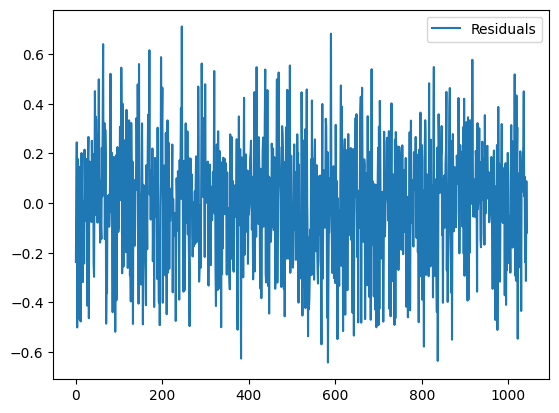

In [ ]:
developing_residuals_plot = pd.DataFrame(results.resid,columns=['Residuals']).reset_index(drop=True)
developing_residuals = pd.DataFrame(results.resid,columns=['Residuals'])
developing_residuals_plot.plot()

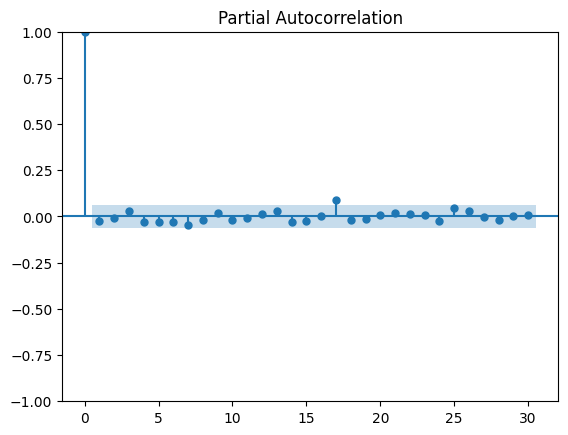

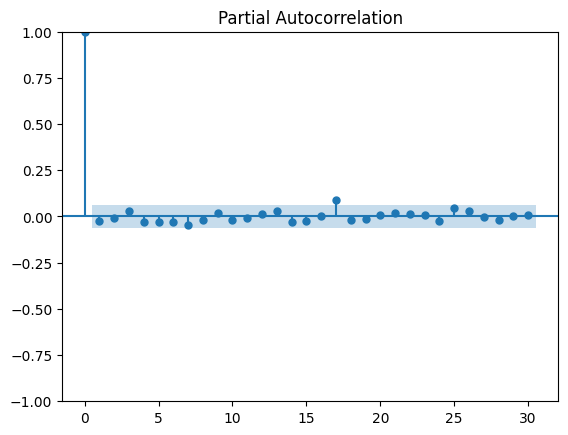

In [ ]:
# Autocorrelation and partial autocorrelation functions
#plot_acf(results.resid, lags=20)  # ACF plot
plot_pacf(results.resid, lags=30)  # PACF plot

- From the above plots, it is noticeable that there is a very weak auto-correlation between residuals.

#### Now, let us see the residuals's distributions by means of an Histogram.

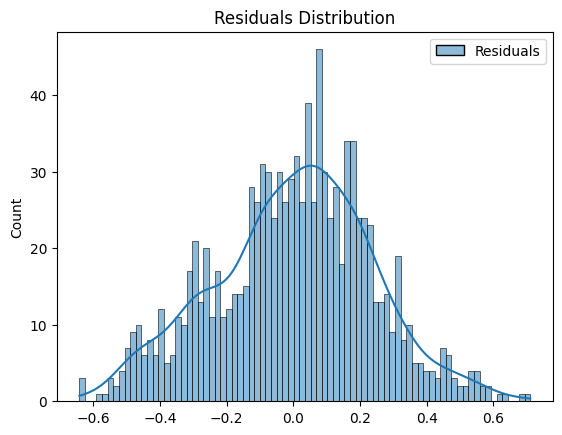

In [ ]:
# Residuals distribution
plt.subplot(1, 1, 1)
sns.histplot(developing_residuals, kde=True, bins=80)
plt.title('Residuals Distribution')
plt.show()

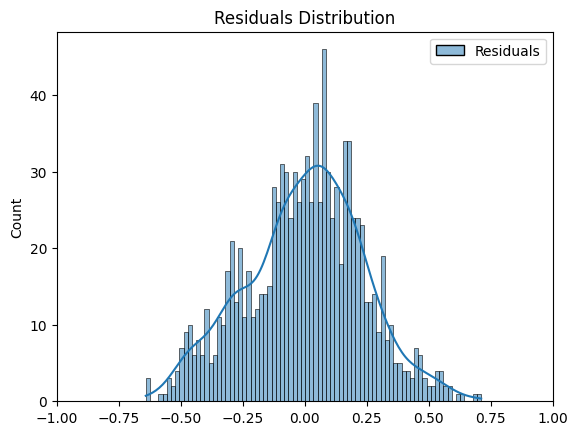

In [ ]:
# Residuals distribution
plt.subplot(1, 1, 1)

sns.histplot(developing_residuals, kde=True,bins=80)

plt.title('Residuals Distribution')
plt.xlim([-1,1])

plt.show()

#### Residuals Normality Tests

- Now, in order to know whether the residuals's distribution is Gaussian-like or not, let us make a Shapiro statistical test, as well as QQ-Plot.


In [ ]:
alpha = 0.05

# Perform the test and obtain test statistic and p-value
#stat, p_value = shapiro(developed_residuals)
stat, p_value = shapiro(developing_residuals[developing_residuals['Residuals']>-1.5])
if p_value > alpha:
    print(f"The residuals follow a normal distribution (fail to reject H0), the p-values is {p_value}")
else:
    print(f"The residuals do not follow a normal distribution (reject H0), the p-values is {p_value}")
# Interpretation:
# - p-value > 0.05 suggests normality at the 95% confidence level.

The residuals do not follow a normal distribution (reject H0), the p-values is 0.000457642920082435


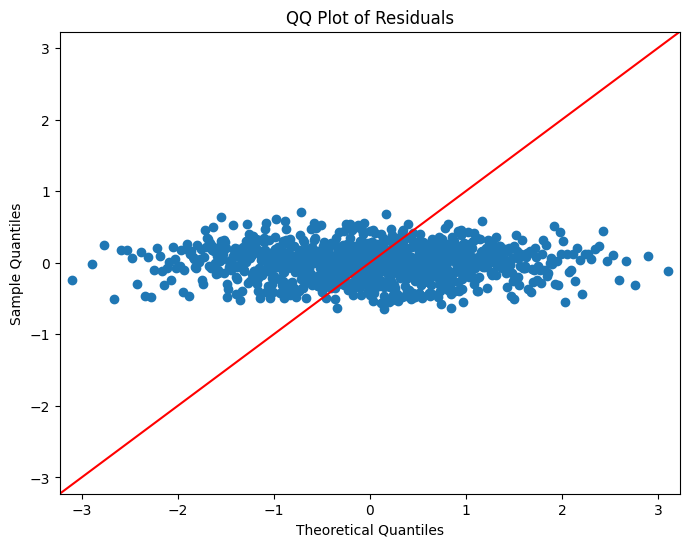

In [ ]:
# Create a QQ plot
fig, ax = plt.subplots(figsize=(8, 6))
#sm.qqplot(developed_residuals, line='45', ax=ax)
sm.qqplot(developing_residuals, line='45', ax=ax)
ax.set_title('QQ Plot of Residuals')

plt.show()

### Partial Conclusions from Statistical modeling:

1. a

## Machine Learning Modeling

- In this part, a model will be created by using a Random Forest Regressor and check its performance in the Training and Testing Sets. Afterwards, feature importances plots and **XAI** with SHAP will be performed in order to get insights from model's predictions.

In [ ]:
# Fitting a Random Forest Regressor
model_scikit = RandomForestRegressor(n_estimators=200)
model_scikit.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200)

- Let us check the model's performance in the Training and Testing sets.

In [ ]:
pred_train = model_scikit.predict(X_train)
r2_score(y_train,pred_train)

0.9922897836351441

In [ ]:
pred_test = model_scikit.predict(X_test)
r2_score(y_test,pred_test)

0.9059497594207696

- Now, let us make a features importance plot of the life expectancy's predictors.

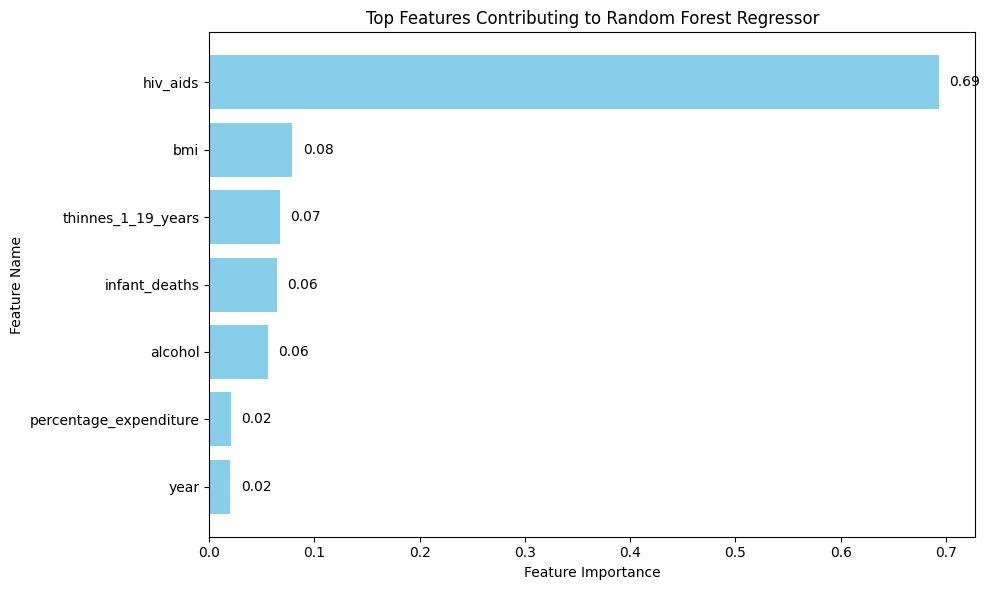

In [ ]:
# Assuming you have feature importances and feature names stored in variables
feature_names = model_scikit.feature_names_in_
feature_importances = model_scikit.feature_importances_ # List of importance values


# Create a DataFrame for clearer visualization
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort by importance in descending order
importance_df_sorted = importance_df.sort_values(by='importance', ascending=False)

# Separate top N features for highlighting
top_features = importance_df_sorted[:]['feature'].tolist()
top_importances = importance_df_sorted[:]['importance'].tolist()

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top Features Contributing to Random Forest Regressor')

# Annotate top features with their importance values
for i, (feature, importance) in enumerate(zip(top_features, top_importances)):
    plt.text(importance + 0.01, i, f'{importance:.2f}', va='center', fontsize=10)

plt.gca().invert_yaxis()  # Display most important features on top
plt.tight_layout()
plt.show()

- From the plot above, it can be noticed that 'hiv_aids', 'alcohol', 'infant_deaths' and thinnes_19_years' are the most important features contributing to Life Expectancy of developed countries. However, we need **SHAP** analysis (**XAI**) to find out how these features correspondingly affect the Life Expectancy in terms of their low and high values.

### XAI

- In order to get valuable insights from the model's predictions, **SHAP** analysis will be used.

In [ ]:
# Using a TreeExplainer for the RF model.
explainer = shap.TreeExplainer(model_scikit)
# Calculate SHAP values for the test set (or specific data you want to explain)
shap_values = explainer(X_test)  # Or explainer(X_train) for training data

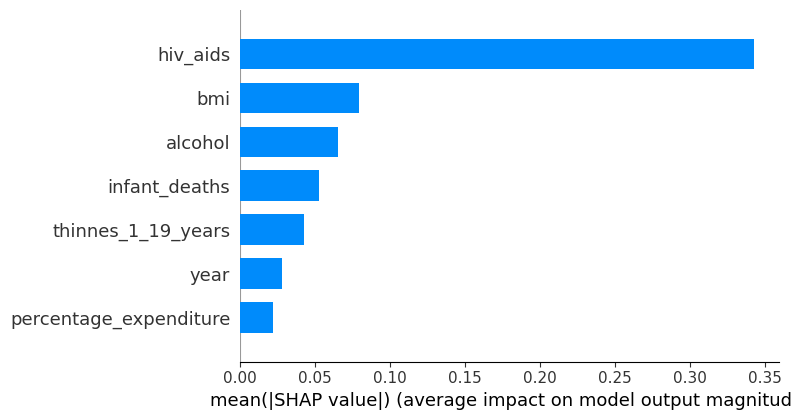

In [ ]:
# plotting a feature's importance plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

- It can be seen that this features importance from **SHAP** is in accordance with the traditional feature's importance shown previously.

#### Bee-swarm and Violin Plots

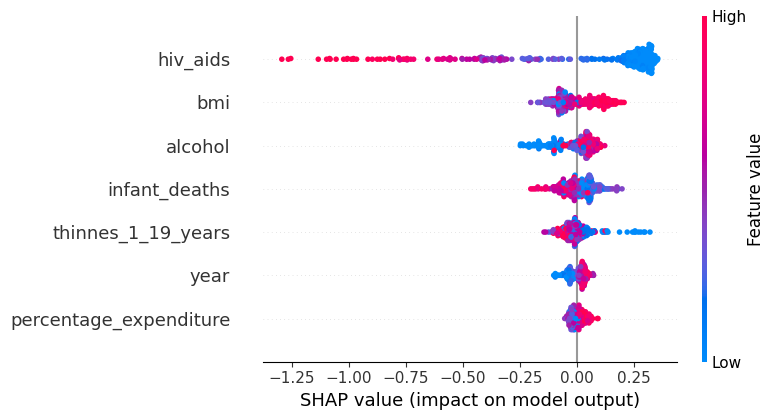

In [ ]:
# Bee-swarm plot of shap_values in the Test Set
shap.summary_plot(shap_values, X_test)


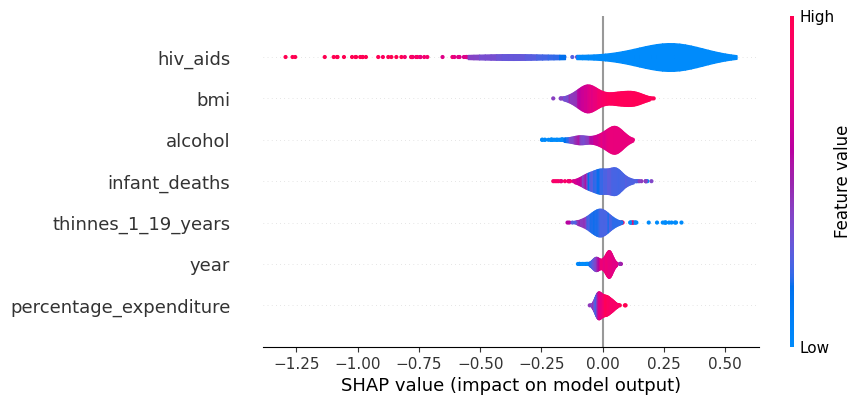

In [ ]:
# Violin plot of shap_values in the Test Set
shap.plots.violin(
    shap_values, feature_names=X_test.columns)

- From the above plots, we can note that:
1. the lower the value of 'hiv_aids', the higher the SHAP value and, so, the higher the Life Expectancy;
2. the higher the value of 'alcohol', the higher the SHAP value and, so, the higher the Life Expectancy. This is, somehow, controversial;
3. the lower the value of 'infant_deaths', the higher the SHAP value and, so, the higher the Life Expectancy;
4. the lower the value of 'thinnes_1_19_years', the higher the SHAP value and, so, the higher the Life Expectancy;
5. the higher the value of 'bmi', the higher the SHAP value and, so, the higher the Life Expectancy;
6. the higher the value of 'percentage_expenditure', the higher the SHAP value and, so, the higher the Life Expectancy;
7. the higher the value of 'year', the higher the SHAP value and, so, the higher the Life Expectancy. This points out that the Life Expectancy tends to increase with the years;

- Let us create a heatmap out of the **SHAP** values.

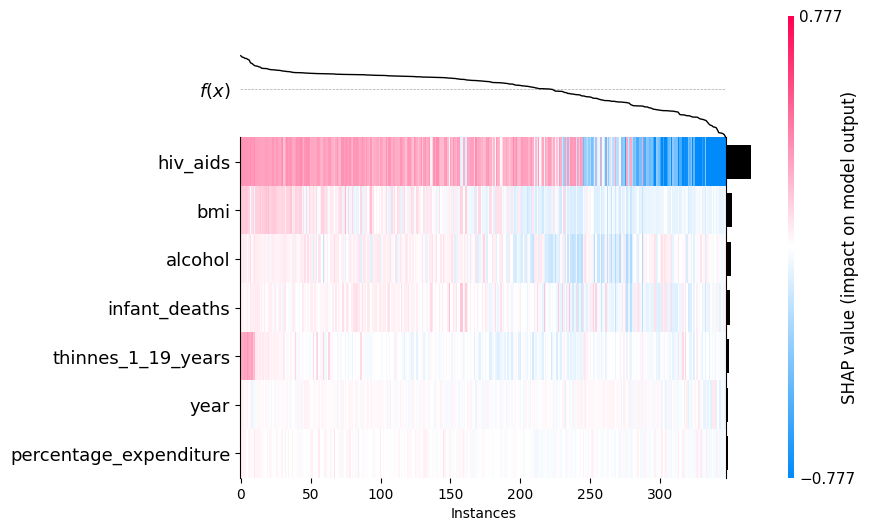

In [ ]:
# Create the aggregated plot with feature names
shap.plots.heatmap(shap_values,max_display=X_test.shape[1], instance_order=shap_values.sum(1))

- From the above **Heatmap Plot**, we can see the impact on model output for each instance in terms of each feature contributing to Life Expectancy. Mostly, we can notice that **'hiv_aids'** is for almost the first 250 contributing to increase the life's expectancy, and for the remainder instances mostly to decrease Life Expectancy. The remaining features do not play a significant role in the prediction results, except **'thinnes_1_19_years'** for the first about 20-25 instances.